# Imports

In [2]:
import sys, os
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/fig"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/src/data"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/src/output"))
sys.path.append(os.path.abspath("C:/users/karmeni1/project/lm-mem/src"))
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle

from stimuli import prefixes, prompts
import json
import logging
logging.basicConfig(format="[INFO] %(message)s", level=logging.INFO)

In [28]:
# set some matplotlib options to handle text better
# default color cycle: ['00BEFF', 'D4CA3A', 'FF6DAE', '67E1B5', 'EBACFA', '9E9E9E', 'F1988E', '5DB15A', 'E28544', '52B8AA']
# taken from: https://gist.github.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea
plt.style.use("gadfly")

# scale font sizes
sns.set_context('paper', font_scale=1.6)

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Define directories

In [60]:
home_dir = os.path.join(os.environ['homepath'], "project", "lm-mem")
data_dir = os.path.join(home_dir, "data", "outputs")
savedir = os.path.join(home_dir, "fig", "raw")
table_savedir = os.path.join(home_dir, "tables", "revised")
savefigs = True

# Helper functions

## plot_example()

In [6]:
#wrapper function
def plot_example(x, y, markers, xlabels, ylabel, fh, fw, ylim, title):
    
    usetex = plt.rcParams["text.usetex"]
    
    f, a = plt.subplots(figsize=(fw, fh))

    a.plot(x, y, marker='o', linestyle="--")
    
    if ylim is None:
        ylim = a.get_ylim()
    
    x_rect = np.where(xlabels==xlabels[markers==3][0])[0]
    y_rect = ylim[0]
                      
    for i, xloc in enumerate(x_rect):             
        a.add_patch(Rectangle(xy=(xloc-0.5, y_rect), width=len(xlabels[markers==1]), height=ylim[-1]+0.5, 
                               edgecolor=None, facecolor="tab:blue", alpha=0.15))
        
    a.set_xticks(x);
    
    # escape underscore if latex is used for rendering
    if usetex:
        xlabels = [lab.replace("_", "\_").replace("<", "").replace(">", "") for lab in xlabels]
    a.set_xticklabels(xlabels, rotation=40, fontsize=12, ha="right");

    bluewords = np.isin(markers, [1, 3])

    [t.set_color("tab:blue") for i, t in enumerate(a.xaxis.get_ticklabels()) if bluewords[i]]

    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.set(ylabel=ylabel, title=title);
    
    return f, a

## set_bars_hatches()

In [7]:
def set_bars_hatches(axes, patterns):
    """
    taken from: https://stackoverflow.com/questions/55826167/matplotlib-assigning-different-hatch-to-bars
    """
    bars = axes.patches

    hatches = []          # list for hatches in the order of the bars
    for h in patterns:    # loop over patterns to create bar-ordered hatches
        for i in range(int(len(bars) / len(patterns))):
            hatches.append(h)
    for bar, hatch in zip(bars, hatches):  # loop over bars and hatches to set hatches in correct order
        bar.set_hatch(hatch)

## make_bar_plot()

In [8]:
def make_bar_plot(data_frame, estimator, x, y, hue, col,
                  ylim=None, xlabel=None, ylabel=None, suptitle=None,
                  size_inches=(5, 3), legend=False, legend_out=False, legend_title=None,
                  hue_order=["Repeated", "Permuted", "Novel"], col_order=["arbitrary", "semantic"]):


    g = sns.catplot(data=data_frame, x=x, y=y, hue=hue, col=col, 
                    estimator=estimator, ci=95.0,
                    kind="bar", dodge=0.5, zorder=2, legend=legend, legend_out=legend_out,
                    seed=12345,
                    hue_order=hue_order, col_order=col_order,
                    edgecolor=["white"], ecolor=["tab:gray"], bottom=0, linewidth=1)
    
    ax = g.axes[0]

    # set hatches manually
    hatch_patterns = ['-', '/', '\\']
    set_bars_hatches(axes=ax[0], patterns=hatch_patterns)
    set_bars_hatches(axes=ax[1], patterns=hatch_patterns)
    
    # set labels
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    
    if len(ax) == 2:
        ax[1].set_xlabel(xlabel)
        ax[1].set_ylabel("")
        
    # set ylim if needed
    if ylim is not None:
        ymin, ymax = ylim
        if ymin is None: ymin = ax[0].get_ylim()[0]
        if ymax is None: ymax = ax[0].get_ylim()[1]
        
        ax[0].set(ylim=(ymin, ymax))
    
    #blue, orange, green = sns.color_palette("dark")[0:3]
    n_x_groups = len(data_frame[x].unique())
    
    # annotate
    x_levels = data_frame.loc[:, x].unique()
    col_levels = data_frame.loc[:, col].unique()
    hue_levels = data_frame.loc[:, hue].unique()
    
    # find n rows for one plotted group
    one_group = (data_frame[x]==x_levels[0]) & (data_frame[hue]==hue_levels[0]) & (data_frame[col] == col_levels[0])
    n = len(data_frame.loc[one_group])  
    print("N per group == {}".format(n))
    
    # find numerical values
    ci = {}
    for k, a in enumerate(ax):
        d = {lab: [] for lab in hue_order}
        ci[col_order[k]] = {"{}-{}".format(lab, x_levels[j]): plot_obj[0].get_ydata().tolist() + [plot_obj[1].get_height()]
                                                           for i, lab in enumerate(hue_order)
                                                           for j, plot_obj in enumerate(zip(a.lines[0+(i*n_x_groups):n_x_groups+(i*n_x_groups)],
                                                                                            a.patches[0+(i*n_x_groups):n_x_groups+(i*n_x_groups)]))}
    
    # convert dict to a "record" list with observation per row                                                      
    rec = [[key1, key.split("-")[0], key.split("-")[1], ci[key1][key][0], ci[key1][key][1], ci[key1][key][2]] for key1 in ci.keys() for key in ci[key1].keys()]
    
    ci_df = pd.DataFrame.from_records(rec, columns=[col, hue, x, "ci_min", "ci_max", "median"])
    
    # legend
    # Improve the legend
    if not legend:
        
        axis_with_legend = 0
        if len(ax) == 2:
            axis_with_legend = 1
            #ax[0].get_legend().remove()
        
        handles, labels = ax[axis_with_legend].get_legend_handles_labels()
        ax[axis_with_legend].legend(handles[0:3], labels[0:3], labelcolor=['#00BEFF', '#D4CA3A', '#FF6DAE'],
                                    handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1),
                                    loc="upper left", ncol=1, frameon=False, title=legend_title)

    g.fig.suptitle("{}".format(suptitle))
    g.set_titles(col_template="{col_name} lists of nouns")
    #g.despine(left=True)
    g.fig.set_size_inches(size_inches[0], size_inches[1])
    
    return g, ax, ci_df

## get_data_lineplot_with_bars()

In [9]:
def get_data_lineplot_with_bars(axis):
    
    """
    extract data from a line plot (errbar) with error bars
    
    Parameters:
    axis : AxisSubplot()
    
    Returns:
     : DataFrame()
    """
    
    labels = axis.get_legend_handles_labels()[-1]
    n_groups = len(labels)
    group_size = int(len(axis.lines)/n_groups)
    
    data_dict = {key: {"est": None, "err": None} for key in labels}
    
    tmplist = []
    for n in range(n_groups):
        
        tmp = pd.DataFrame(columns=["est", "ci_max", "ci_min"])
        
        beg_element = n * group_size
        end_element = beg_element + group_size
        
        tmp["est"] = axis.lines[beg_element].get_data()[-1]
        tmp["ci_min"] = [axis.lines[i].get_data()[-1][0] for i in range(beg_element+1, end_element)]
        tmp["ci_max"] = [axis.lines[i].get_data()[-1][1] for i in range(beg_element+1, end_element)]
        tmp["xlabel"] = [xticklabel.get_text() for xticklabel in axis.get_xticklabels()]
        tmp["hue"] = labels[n]
        tmplist.append(tmp)
    
    return pd.concat(tmplist)

## set_color_error_bars()

In [10]:
def set_color_error_bars(axis, color, n_lines, n_points):
    
    lines = axis.lines
    total = n_lines*n_points + n_lines # every line has n_points
    to_skip = np.arange(0, total, int(total/n_lines))
    
    indices = np.array([idx for idx in np.arange(0, total) if idx not in to_skip])
    for index in indices:
        lines[index].set_color("gray")

## set_linewidths()

In [11]:
def set_linewidths(axis, lw, n_lines, n_points):
    
    total = n_lines*n_points + n_lines # every line has n_points
    to_consider = np.arange(0, total, int(total/n_lines))
    
    for idx in to_consider:
        axis.lines[idx].set_linewidth(lw)
    


## set_marker_colors()

In [12]:
def set_marker_colors(axis, facecolor, edgecolor):

    for col in axis.collections:
        if facecolor is not None: col.set_facecolor(facecolor)
        if edgecolor is not None: col.set_edgecolor(edgecolor)

## make_point_plot()

In [13]:
def make_point_plot(data_frame, estimator, x, y, hue, style, col,
                   xlabel=None, ylabel=None, suptitle=None, suptitle_fs=18, ylim=(None, None),
                   size_inches=(5, 3), join=True, scale=1, errwidth=None,
                   legend=False, legend_out=False, custom_legend=True, legend_title=None, 
                   hue_order=["Repeated", "Permuted", "Novel"], col_order=["arbitrary", "semantic"]):
    
    g = sns.catplot(data=data_frame, x=x, y=y, hue=hue, col=col, 
                    estimator=estimator, errorbar=('ci', 95.0),
                    kind="point", join=join, dodge=0.2, scale=scale, errwidth=errwidth,
                    linestyles=["solid", "dotted", "dashed"], markers=['o', 's', 'D'],
                    legend=legend, legend_out=legend_out,
                    seed=12345,
                    hue_order=hue_order, col_order=col_order)
    
    ax = g.axes[0]

    # manually set erorbar color
    #set_color_error_bars(axis=ax[0], color="black", n_lines=3, n_points=4)
    #set_color_error_bars(axis=ax[1], color="black", n_lines=3, n_points=4)
    
    #set_marker_colors(axis=ax[0], facecolor=None, edgecolor="darkgray")
    #set_marker_colors(axis=ax[1], facecolor=None, edgecolor="darkgray")
    
    set_linewidths(axis=ax[0], lw=1.5, n_lines=3, n_points=4)
    set_linewidths(axis=ax[1], lw=1.5, n_lines=3, n_points=4)
    
    # set labels
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel("")
    ax[0].set_xlabel(xlabel)
    ax[1].set_xlabel(xlabel)
    
    # set ylim if needed
    if ylim is not None:
        ymin, ymax = ylim
        if ymin is None: ymin = ax[0].get_ylim()[0]
        if ymax is None: ymax = ax[0].get_ylim()[1]
        
        ax[0].set(ylim=(ymin, ymax))
    
    blue, orange, green = sns.color_palette("dark")[0:3]
    n_x_groups = len(data_frame[x].unique())
    
    # annotate
    x_levels = data_frame.loc[:, x].unique()
    col_levels = data_frame.loc[:, col].unique()
    hue_levels = data_frame.loc[:, hue].unique()

    # find n rows for one plotted group
    one_group = (data_frame[x]==x_levels[0]) & (data_frame[hue]==hue_levels[0]) & (data_frame[col] == col_levels[0])
    n = len(data_frame.loc[one_group])  
    print("N per group == {}".format(n))
    
    tmp = []
    for i, a in enumerate(ax):
        tmp_df = get_data_lineplot_with_bars(axis=a)
        tmp_df["cond"] = col_order[i].capitalize()
        tmp.append(tmp_df)
        
    ci_df = pd.concat(tmp)
    
    # legend
    # Improve the legend
    if custom_legend:
        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(handles[0:3], labels[0:3], labelcolor=['#00BEFF', '#D4CA3A', '#FF6DAE'], fontsize=16,
                     markerscale=1.4, handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1),
                     loc="upper left", ncol=1, frameon=False, facecolor='white', framealpha=0.2, 
                     title=legend_title, title_fontsize=17)

    g.fig.suptitle(f"{suptitle}", fontsize=suptitle_fs)
    g.set_titles(col_template="{col_name} lists")
    g.despine(left=True)
    g.fig.set_size_inches(size_inches[0], size_inches[1])
    
    return g, ax, ci_df

## make_timecourse_plot()

In [86]:
def make_timecourse_plot(datain, x, style, col, col_order, style_order, hue_order, estimator, err_style, xticks):
    
    usetex = plt.rcParams["text.usetex"]
    
    # annotate
    x_levels = datain.loc[:, x].unique()          # x group
    col_levels = datain.loc[:, col].unique()      # column grouping
    style_levels = datain.loc[:, style].unique()
    
    # find n rows (observations) for one plotted group
    one_group = (datain[x] == x_levels[-1]) & (datain[style] == style_levels[0]) & (datain[col] == col_levels[0])
    n = len(datain.loc[one_group])  
    
    p = sns.relplot(kind="line", data=datain, x=x, y="surp", style=style, hue=style, col=col, 
                    estimator=estimator, errorbar=("ci", 95.0), err_style=err_style, seed=12345,
                    markers=True, style_order=style_order, hue_order=hue_order, col_order=col_order,
                    legend=True, linewidth=0.7)
    
    # get the data hre
    ax = p.axes[0]
    
    # create a list of lists
    rec = [[col_order[k], style_order[i], int(seg[1, 0]), coll[0].get_ydata()[j], seg[0, 1], seg[1, 1]] 
             for k, a in enumerate(ax)
             for i, coll in enumerate(a.containers) 
             for j, seg in enumerate(coll[2][0].get_segments())]
    
    colnames = [col, style, x, "median", "ci_min", "ci_max"]
    stat = pd.DataFrame.from_records(rec, columns=colnames)
    
    p.set_titles(col_template="{col_name} list")
    p.despine(left=True);
    
    return p, ax, stat

## get_relative_change()

In [15]:
# Define function that computes relative change in average surprisal

def get_relative_change(x1=None, x2=None, labels1=None, labels2=None):
    
    """
    computes relative change across data in x1 and x2. Sizes of arrays x1 and x2
    should match.
    """
    
    # check that any labels match
    if (labels1 is not None) & (labels2 is not None):
        assert (labels1 == labels2).all()
    
    x_del = ((x2-x1)/(x1+x2))
    x_perc = (x2/x1)*100
    return x_del, x_perc

## relative_change_wrapper()

In [16]:
def relative_change_wrapper(df_agg, groups, compared_col):
    
    # unpack the dicts
    g1, g2, g3, g4 = groups
    
    # define coloms for data
    col1 = list(g1.keys())[0]
    col2 = list(g2.keys())[0]
    col3 = list(g3.keys())[0]
    col4 = list(g4.keys())[0]
    
    # apply relative change computation and apply to 
    df_list = []
    for val1 in list(g1.values())[0]:
        for val2 in list(g2.values())[0]:
            for val3 in list(g3.values())[0]:
                for val4 in list(g4.values())[0]:

                    # initialize output dataframe
                    cols = ["x1", "x2", "x_del"]
                    df = pd.DataFrame(columns=cols)
                        
                    # select the correct rows
                    select = (df_agg.loc[:, col1] == val1) & \
                             (df_agg.loc[:, col2] == val2) & \
                             (df_agg.loc[:, col3] == val3) & \
                             (df_agg.loc[:, col4] == val4)
                    
                    tmp = df_agg.loc[select].copy()

                    # get vectors with aggregated surprisal values from first and second list
                    x1=tmp.loc[tmp.marker==1, compared_col].to_numpy()           # average per sentence surprisal on first list
                    x2=tmp.loc[tmp.marker==3, compared_col].to_numpy()           # average per sentence surprisal on second list
                    labels1 = tmp.loc[tmp.marker==1].stimid.to_numpy()  # use sentence id for check
                    labels2 = tmp.loc[tmp.marker==3].stimid.to_numpy()

                    # compute change and populate output dfs
                    x_del, x_perc = get_relative_change(x1=x1, x2=x2, labels1=labels1, labels2=labels2)
                    
                    df["x1"], df["x2"], df["x_del"], df["x_perc"] = x1, x2, x_del, x_perc
                    df[col1], df[col2], df[col3], df[col4] = val1, val2, val3, val4

                    df_list.append(df)
    
    return pd.concat(df_list)

## make_example_plot()

In [17]:
def make_example_plot(data, seed, model_id, title, ylim=None, context="intact"):
    
    # pick a random sentence
    rng = np.random.RandomState(seed)
    sentid = rng.randint(low=1, high=229)

    sel = (data.prompt_len==8) & \
          (data.list_len==5) & \
          (data.second_list=="repeat") & \
          (data.context==context) & \
          (data.list=="random") & \
          (data.stimid == sentid) & \
          (data.model_id==model_id) & \
          (~data.token.isin([" ", "<|endoftext|>"]))
    
    if sum(sel) == 0:
        logging.info("No rows were selected, check conditions.")
    
    dat = data.loc[sel]
    
    x = dat.loc[dat.stimid==sentid].reset_index().index.values
    y = dat.loc[dat.stimid==sentid].surp.to_numpy()
    m = dat.loc[dat.stimid==sentid].marker.to_numpy()
    l = dat.loc[dat.stimid==sentid].token.to_numpy()
    
    # plot
    f, a = plot_example(x=x, y=y, markers=m, xlabels=l, ylabel="surprisal", ylim=ylim, fh=1.5, fw=15, title=title)
    
    return f, a

## select_data_for_timecourse()

In [18]:
def select_data_for_timecourse(data, context_len, list_len, context, model_tags, timesteps=list(range(-4, 10))):
    
    sel = (data.prompt_len == context_len) & \
          (data.list_len == list_len) & \
          (data.list.isin(["categorized", "random"])) & \
          (data.context == context) & \
          (data.model_id.isin(model_tags)) & \
          (data.marker.isin([2, 3])) & \
          (data.second_list.isin(["repeat", "permute", "control"])) &\
          (data.marker_pos_rel.isin(timesteps))
    
    if np.sum(sel) == 0:
        logging.info("No rows were selected, check selection conditions.")
    
    return data.loc[sel].copy()

# Example time courses

## Load data

In [390]:
data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_sce1.csv"), sep="\t", index_col=0)
data_40m = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12_sce1.csv"), sep="\t", index_col=0)

data_rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_sce1.csv"), sep="\t", index_col=None)
data_rnn2 = pd.read_csv(os.path.join(data_dir, "output_rnn-vs2019_a-70_sce1.csv"), sep="\t", index_col=None)

data_rnn.rename(columns={"word": "token"}, inplace=True)
data_rnn2.rename(columns={"word": "token"}, inplace=True)
data_rnn["model"] = "lstm"
data_rnn2["model"] = "lstm"

data_gpt["model"] = "gpt-2"
data_40m["model"] = "gpt-2"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Data check

In [33]:
# show original and target lists for stimulus input 11
for dat in (data_gpt, data_40m):
    
    sel = (dat.list_len==5) & (dat.prompt_len==8) & (dat.context=="intact") & (dat.list=="random") & (dat.second_list=="permute") & (dat.marker.isin([1, 3]))
    d = dat.loc[sel]
    stimid=11
    display("Original and target lists for stimulus {}:".format(stimid))
    display(d.loc[d.stimid==stimid, ["token", "marker", "model", "second_list"]])

'Original and target lists for stimulus 11:'

,token,marker,model,second_list
2476204,costume,1,gpt-2,permute
2476205,pleasure,1,gpt-2,permute
2476206,pattern,1,gpt-2,permute
2476207,leader,1,gpt-2,permute
2476208,culture,1,gpt-2,permute
2476231,culture,3,gpt-2,permute
2476232,pleasure,3,gpt-2,permute
2476233,leader,3,gpt-2,permute
2476234,costume,3,gpt-2,permute
2476235,pattern,3,gpt-2,permute


'Original and target lists for stimulus 11:'

,token,marker,model,second_list
2476204,costume,1,gpt-2,permute
2476205,pleasure,1,gpt-2,permute
2476206,pattern,1,gpt-2,permute
2476207,leader,1,gpt-2,permute
2476208,culture,1,gpt-2,permute
2476231,culture,3,gpt-2,permute
2476232,pleasure,3,gpt-2,permute
2476233,leader,3,gpt-2,permute
2476234,costume,3,gpt-2,permute
2476235,pattern,3,gpt-2,permute


## Make plots

Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce1_trf-a-10.
Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce1_trf-w-12.
Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce1_lstm-a-10.
Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce1_lstm-a-70.


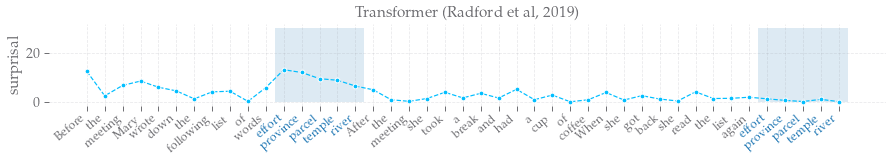

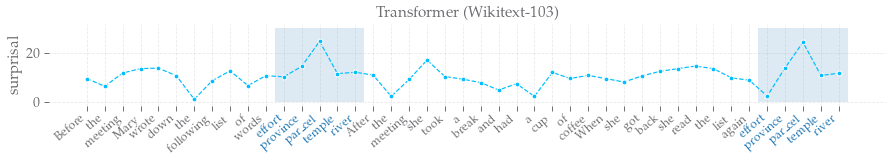

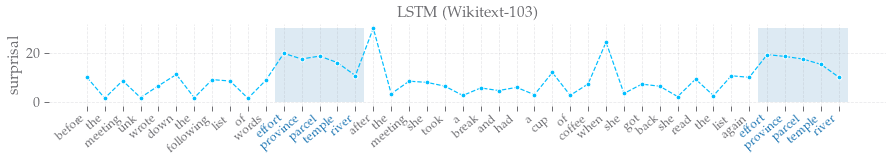

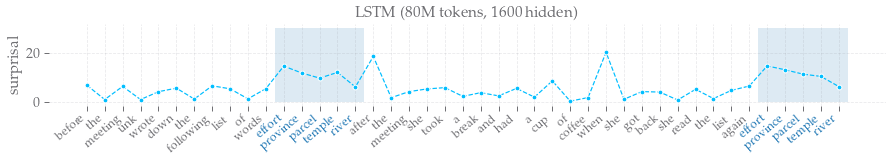

In [34]:
ids = ("a-10", "w-12", "a-10", "a-70")
tags = ("trf", "trf", "lstm", "lstm")
titles = ("Transformer (Radford et al, 2019)", "Transformer (Wikitext-103)", "LSTM (Wikitext-103)", "LSTM (80M tokens, 1600 hidden)")
scenario = "sce1"

for dat, model_id, tag, title in zip((data_gpt, data_40m, data_rnn, data_rnn2), ids, tags, titles):

    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, context="intact", ylim=(0, 30), title=title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

## Bert: load data

In [39]:
data_bert = pd.read_csv(os.path.join(data_dir, "output_bert_b-10_sce1.csv"), sep="\t", index_col=0)
data_bert["model"] = "bert"
data_bert["model_id"] = "b-10"
data_bert["context"] = "intact"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [41]:
# show original and target lists for stimulus input 11
for dat in (data_bert,):
    
    sel = (dat.list_len==10) & (dat.prompt_len==8) & (dat.context=="intact") & (dat.list=="random") & (dat.second_list=="permute") & (dat.marker.isin([1, 3]))
    d = dat.loc[sel]
    stimid=11
    display("Original and target lists for stimulus {}:".format(stimid))
    display(d.loc[d.stimid==stimid, ["token", "marker", "model", "second_list", "list_len"]])

'Original and target lists for stimulus 11:'

,token,marker,model,second_list,list_len
37164,costume,1,bert,permute,10.0
37165,pleasure,1,bert,permute,10.0
37166,pattern,1,bert,permute,10.0
37167,leader,1,bert,permute,10.0
37168,culture,1,bert,permute,10.0
37169,worker,1,bert,permute,10.0
37170,master,1,bert,permute,10.0
37171,meadow,1,bert,permute,10.0
37172,writer,1,bert,permute,10.0
37173,apple,1,bert,permute,10.0


## Bert: make plots

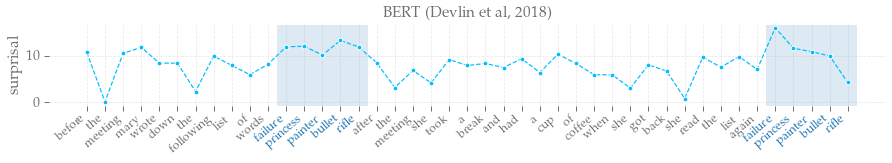

In [44]:
ids = ("b-10",)
tags = ("mlm",)
titles = ("BERT (Devlin et al, 2018)",)
scenario = "sce1"

for dat, model_id, tag, title in zip((data_bert,), ids, tags, titles):

    f, a = make_example_plot(data=dat, seed=45234232, model_id=model_id, context="intact", ylim=None, title=title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

# Timecourse plots 

### Prepare data

In [83]:
data = awd_sce1

# rename some row variables for plotting
new_list_names = {"categorized": "semantic", "random": "arbitrary"}
data.list = data.list.map(new_list_names)

new_second_list_names = {"control": "novel", "repeat": "repeated", "permute": "permuted"}
data.second_list = data.second_list.map(new_second_list_names)

In [84]:
context_len = 8
list_len = 10
context = "intact"

sel = (data.prompt_len == context_len) & \
      (data.list_len == list_len) & \
      (data.list.isin(["semantic", "arbitrary"])) & \
      (data.context == context) & \
      (data.model_id.isin(["a-10"])) & \
      (data.marker.isin([2, 3])) & \
      (data.second_list.isin(["repeated", "permuted", "novel"])) &\
      (data.marker_pos_rel.isin(list(range(-4, 10))))

d = data.loc[sel].copy()

# name column manually
d.rename(columns={"list": "list structure", "second_list": "condition"}, inplace=True)
# capitalize row values
new_second_list_names = {"novel": "Novel", "repeated": "Repeated", "permuted": "Permuted"}
d.condition = d.condition.map(new_second_list_names)

### Plots

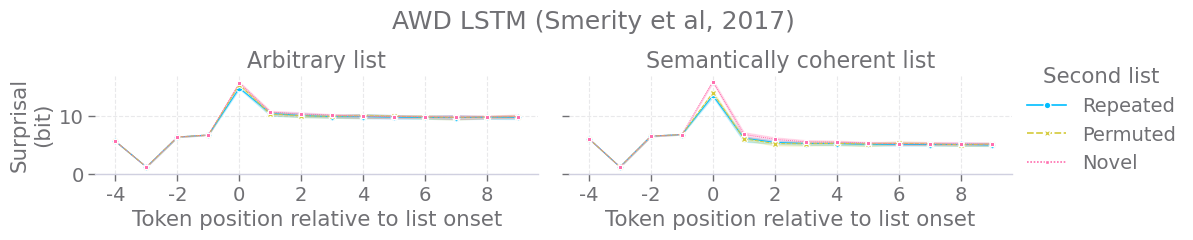

Saving \Users\karmeni1\project\lm-mem\fig\raw\timecourse_sce1_awd-lstm_a-10
Writing \Users\karmeni1\project\lm-mem\tables\revised\timecourse_sce1_awd-lstm_a-10_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\timecourse_sce1_awd-lstm_a-10_table.tex


In [95]:
# common fig properties
w, h = 12, 2

model_ids = ("a-10",)
tags = ("awd-lstm",)
titles = ("AWD LSTM (Smerity et al, 2017)",)
arcs = ("awd_lstm",)
ylims=((0, None),)
scenario = "sce1"

for model_id, suptitle, arc, tag, ylim in zip(model_ids, titles, arcs, tags, ylims):
    
    sel = ((d["model_id"] == model_id) & (d.model == arc))
    
    d.rename(columns={"marker_pos_rel": "marker-pos-rel", "condition": "Second list"}, inplace=True)
    
    p, ax, _ = make_timecourse_plot(d.loc[sel], x="marker-pos-rel", style="Second list", col="list structure",
                                    estimator=np.median,
                                    col_order=["arbitrary", "semantic"], err_style="band", 
                                    hue_order=["Repeated", "Permuted", "Novel"],
                                    style_order=["Repeated", "Permuted", "Novel"],
                                    xticks=list(range(-4, 10)))

    _, _, stat = make_timecourse_plot(d.loc[sel], x="marker-pos-rel", style="Second list", col="list structure", 
                                      estimator = np.median,
                                      col_order=["arbitrary", "semantic"], err_style="bars", 
                                      hue_order=["Repeated", "Permuted", "Novel"],
                                      style_order=["Repeated", "Permuted", "Novel"],
                                      xticks=list(range(-4, 10)))
    
    plt.close(plt.gcf())

    # set ylims
    ymin, ymax = ylim
    if ymin is None: ymin = ax[0].get_ylim()[0]
    if ymax is None: ymax = ax[0].get_ylim()[1]
    ax[0].set(ylim=(ymin, ymax))
    
    ax[0].set_title("Arbitrary list", fontsize=16)
    ax[1].set_title("Semantically coherent list", fontsize=16)
    ax[0].set_ylabel("Surprisal\n(bit)")
    for a in ax:
        a.set_xlabel("Token position relative to list onset")
        a.set_xticks(list(range(-4, 10, 2)))
        a.set_xticklabels(list(range(-4, 10, 2)))
            
    p.fig.suptitle(suptitle, fontsize=18)
    p.fig.set_size_inches(w=w, h=h)
    p.fig.subplots_adjust(top=0.65)

    plt.show()
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "timecourse_{}_{}_{}".format(scenario, tag, model_id))))
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.pdf".format(scenario, tag, model_id)), transparent=True, bbox_inches="tight")
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")
        
        # save numerical tables
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

            # save the original .csv
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.csv".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"list structure": "List", "marker-pos-rel": "Token position"}, inplace=True)
        tex = stat.loc[stat["Token position"].isin(list(range(0, 4))), :]\
                  .pivot(index=["List", "Second list"], columns=["Token position"], values="report_str")\
                  .to_latex(bold_rows=True,
                            label="tab:timecourse_{}_{}_{}".format(scenario, tag, model_id),
                            caption="{} surprisal values for four initial token positions, list type and second list condition.".format(suptitle))

        # now save as .tex file
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.tex".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Set size effect

## filter_and_aggregate()

In [24]:
def filter_and_aggregate(datain, model, model_id, groups, aggregating_metric):
    """
    Parameters:
    ----------
    datain : dataframe
        dataframe which is filtered and aggregated over
    model : string
        string identifying the model in the 'model' column
    model_id: string
        string identifying the id of the model in the 'model_id' column of datain
    groups : list of dicts
        each element is a dict with column name as key and a list of row values as dict value, 
        the first dict should be the variable that's manipulated (e.g. list length),
        the rest are the ones that are held fixed
    """
    # unpack the dictionaries for each variable
    d1, d2, d3, d4 = groups
   
    # define variables for querying below
    var1 = list(d1.keys())[0]  # e.g. .prompt_len
    var2 = list(d2.keys())[0]  # e.g. .list_len
    var3 = list(d3.keys())[0]  # e.g. .context
    var4 = list(d4.keys())[0]  # e.g. .token_positions

    # select the groups based on variable values
    sel = (datain[var1].isin(d1[var1])) & \
          (datain[var2].isin(d2[var2])) & \
          (datain.second_list.isin(["repeat", "permute", "control"])) & \
          (datain.list.isin(["random", "categorized"])) & \
          (datain[var3].isin(d3[var3])) & \
          (datain.model_id==model_id) & \
          (datain.model==model) & \
          (datain.marker.isin([1, 3])) & \
          (datain[var4].isin(d4[var4]))
    
    if sum(sel) == 0:
        logging.info("No rows were selected. Check selection conditions.")
    
    d = datain.loc[sel].copy()
    
    ## Aggregate
    # average separately per list_len, stimulus id (sentid), model (lstm or gpt2), marker (1 or 3), list (random, categorized) and second list (repeated, permuted or control)
    units = [var1, "stimid", "model", "marker", "list", "second_list"]
    
    logging.info("Aggregating metric == {}".format(aggregating_metric))
    logging.info("Aggregating over these variables:")
    display(units)
    
    # aggregate with .groupby and .agg
    dagg = d.groupby(units).agg({"surp": [aggregating_metric, "std"], "token": list}).reset_index()
    dagg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in dagg.columns.values]
    
    target_colname = "surp_" + aggregating_metric    
    ## Compute metric
    dataout = relative_change_wrapper(df_agg=dagg, 
                                      groups = [{"model": [model]}, 
                                                 d1,  # this is the manipulated variable
                                                {"second_list": ["repeat", "permute", "control"]},
                                                {"list": ["categorized", "random"]}
                                                ],
                                      compared_col=target_colname,
                                      )
    
    # rename some column/row names for plotting
    dataout.list = dataout.list.map({"categorized": "semantic", "random": "arbitrary"})
    dataout.rename(columns={"second_list": "condition"}, inplace=True)
    dataout.condition = dataout.condition.map({"control": "Novel", "repeat": "Repeated", "permute": "Permuted"})
    
    return dataout, dagg

## Prepare data

In [402]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["intact"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")
dat_rnn_, _ = filter_and_aggregate(datain=data_rnn, model="lstm", model_id="a-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

## Plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce1_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce1_trf-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-a10.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce1_lstm-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_lstm-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_lstm-a10.tex


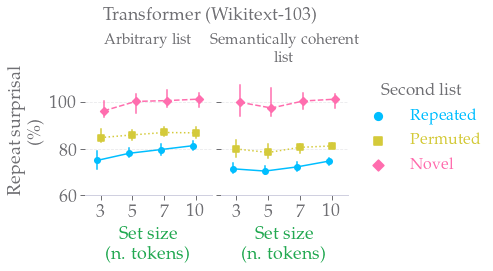

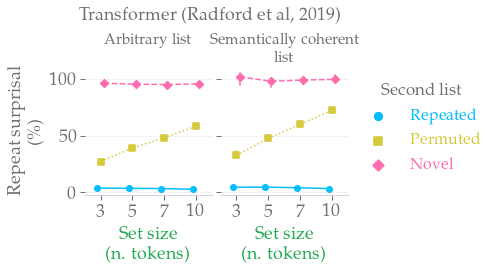

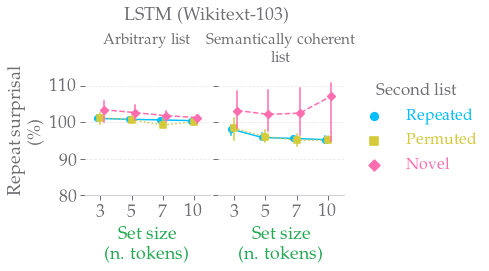

In [404]:
dfs = (dat_40m_, dat_gpt_, dat_rnn_)
suptitles = ("Transformer (Wikitext-103)", "Transformer (Radford et al, 2019)", "LSTM (Wikitext-103)")
savetags = ("trf-w12", "trf-a10", "lstm-a10")
ylims=((60, 115), (None, None), (80, 115))
basename="set-size"
scenario = "sce1"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="list_len", y="x_perc", hue="condition", style="condition", 
                                     col="list", ylim=ylim,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    tick_fs, label_fs = 18, 18
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()): 
            label.set_fontsize(tick_fs)
        a.set_xlabel(a.get_xlabel(), color='#23a952', fontsize=label_fs)

    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=18)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size. We report the percentage of ".format(suptitle) + \
                            "list-averaged surprisal on second relative to first lists. Error bars denote 95\% confidence intervals around " \
                            "the group median (bootstrap estimate). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Context length effect

## Prepare data

In [396]:
variables = [{"prompt_len": [8, 100, 200, 400]},
             {"list_len": [10]},
             {"context": ["intact"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, dat_gpt_, dat_rnn_ = None, None, None
dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")
dat_rnn_, _ = filter_and_aggregate(datain=data_rnn, model="lstm", model_id="a-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['prompt_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['prompt_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['prompt_len', 'stimid', 'model', 'marker', 'list', 'second_list']

In [397]:
dat_40m_.prompt_len = dat_40m_.prompt_len.astype(int)
dat_gpt_.prompt_len = dat_gpt_.prompt_len.astype(int)
dat_rnn_.prompt_len = dat_rnn_.prompt_len.astype(int)

# rename prompt length values to more meaningful ones
prompt_len_map = {8: 26, 30: 47, 100: 99, 200: 194, 400: 435}

dat_40m_.prompt_len = dat_40m_.prompt_len.map(prompt_len_map)
dat_gpt_.prompt_len = dat_gpt_.prompt_len.map(prompt_len_map)
dat_rnn_.prompt_len = dat_rnn_.prompt_len.map(prompt_len_map)

## Plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\inter-text-size_sce1_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\inter-text-size_sce1_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\inter-text-size_sce1_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\inter-text-size_sce1_trf-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\inter-text-size_sce1_trf-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\inter-text-size_sce1_trf-a10.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\inter-text-size_sce1_lstm-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\inter-text-size_sce1_lstm-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\inter-text-size_sce1_lstm-a10.tex


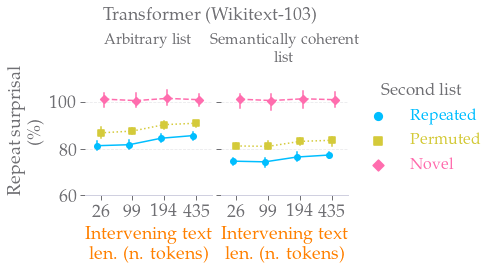

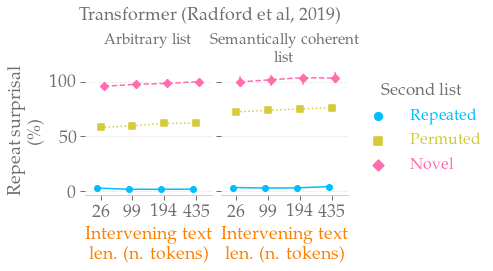

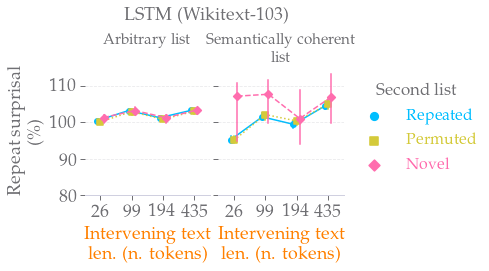

In [400]:
dfs = (dat_40m_, dat_gpt_, dat_rnn_)
suptitles = ("Transformer (Wikitext-103)", "Transformer (Radford et al, 2019)", "LSTM (Wikitext-103)")
savetags = ("trf-w12", "trf-a10", "lstm-a10")
ylims=((60, 115), (None, None), (80, 115))
basename="inter-text-size"
scenario = "sce1"

for df, suptitle, ylim, tag in zip(dfs, suptitles, ylims, savetags):
    
    plot_size=(4, 3)
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="prompt_len", y="x_perc", hue="condition", style="condition",
                                     col="list", ylim=ylim,
                                     xlabel="Intervening text\nlen. (n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    tick_fs, label_fs = 18, 18
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()):
            label.set_fontsize(tick_fs)
        a.set_xlabel(a.get_xlabel(), color="#FF8000", fontsize=label_fs)

    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=label_fs)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Intervening text len."}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Intervening text len."], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of intervening text size. We report the percentage of ".format(suptitle) + \
                            "list-averaged surprisal on second relative to first lists. Error bars denote 95\% confidence intervals around "\
                            "the group median (bootstrap estimate). "\
                            "The list length is fixed at 10 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Effect of context structure

## Prepare data

In [276]:
gptlst, gptlst2, rnnlst = [], [], []
for sce in ["sce1", "sce2", "sce1rnd"]:
    
    logging.info("Loading {}".format(os.path.join(data_dir, "output_rnn_a-10_{}.csv".format(sce))))
    rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_{}.csv".format(sce)), sep="\t", index_col=None)
    rnn.rename(columns={"word":"token"}, inplace=True)
    rnnlst.append(rnn)
    
    logging.info("Loading {}".format(os.path.join(data_dir, "output_gpt2_a-10_{}.csv".format(sce))))
    gptlst.append(pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_{}.csv".format(sce)), sep="\t", index_col=0))
    
    logging.info("Loading {}".format(os.path.join(data_dir, "output_gpt2_w-12_{}.csv".format(sce))))
    gptlst2.append(pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12_{}.csv".format(sce)), sep="\t", index_col=0))

data_gpt = pd.concat(gptlst)
data_40m = pd.concat(gptlst2)
data_rnn = pd.concat(rnnlst)
data_40m["model"] = "gpt-2"
data_gpt["model"] = "gpt-2"
data_rnn["model"] = "lstm"

[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_rnn_a-10_sce1.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_a-10_sce1.csv
C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_w-12_sce1.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_rnn_a-10_sce2.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_a-10_sce2.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_w-12_sce2.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_rnn_a-10_sce1rnd.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_a-10_sce1rnd.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_w-12_sc

In [277]:
variables = [{"context": ["intact", 'scrambled', 'incongruent']},
             {"prompt_len": [400]},
             {"list_len": [10]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, dat_gpt_, dat_rnn_ = None, None, None
dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")
dat_rnn_, _ = filter_and_aggregate(datain=data_rnn, model="lstm", model_id="a-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['context', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['context', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['context', 'stimid', 'model', 'marker', 'list', 'second_list']

## Plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\filler-type_trf-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\filler-type_trf-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\filler-type_trf-a10.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\filler-type_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\filler-type_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\filler-type_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\filler-type_lstm-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\filler-type_lstm-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\filler-type_lstm-a10.tex


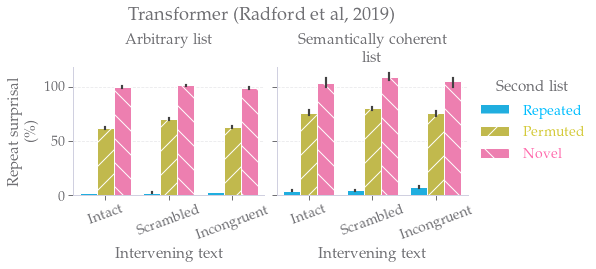

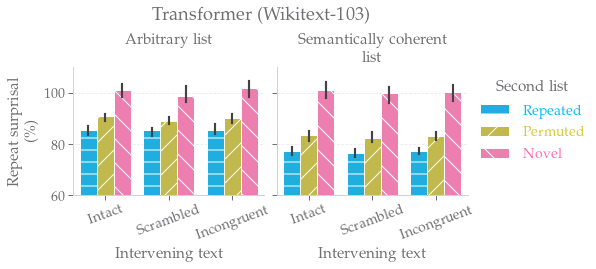

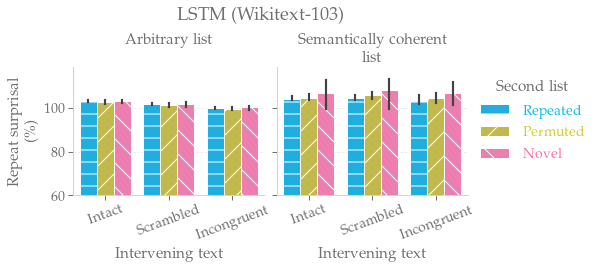

In [278]:
dfs = (dat_gpt_, dat_40m_, dat_rnn_)
suptitles = ("Transformer (Radford et al, 2019)", "Transformer (Wikitext-103)", "LSTM (Wikitext-103)")
savetags = ("trf-a10", "trf-w12", "lstm-a10")
ylims = ((None, None), (60, None), (60, None))
basename = "filler-type"

for df, suptitle, ylim, tag in zip(dfs, suptitles, ylims, savetags):
    
    plot_size=(6, 3)
    
    grid, ax, stat = make_bar_plot(data_frame=df, estimator=np.median, x="context", y="x_perc", hue="condition", col="list", ylim=ylim,
                                 xlabel="Intervening text", ylabel="Repeat surprisal\n(\%)",
                                 suptitle=suptitle,
                                 legend=False, legend_out=True, legend_title="Second list",
                                 size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    xlabels_capitalized = [text.get_text().capitalize() for text in ax[0].get_xticklabels()]
    ax[0].set_xticklabels(labels=xlabels_capitalized, rotation=20)
    ax[1].set_xticklabels(labels=xlabels_capitalized, rotation=20)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}.".format(basename, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}.pdf".format(basename, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}.png".format(basename, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}.csv".format(basename, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.list = stat.list.str.capitalize()
        stat.rename(columns={"condition": "Condition", "list": "List", "context": "Context"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Context"], values="report_str")
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}".format(basename, tag),
                            caption="{} word list surprisal as a function of intervening context. We report the percentage of ".format(suptitle) + \
                            "list-averaged surprisal on second relative to first lists. Error bars denote 95\% confidence intervals around "\
                            "the observed median (bootstrap estimate). "\
                            "The set-size and the length of intervening text are fixed at 10, and 435 tokens, respectively.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}.tex".format(basename, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Effect of short context

In [279]:
scenario = "sce3"

gpt_id = "w-12"
data_gpt40m = pd.read_csv(os.path.join(data_dir, "output_gpt2_{}_{}.csv".format(gpt_id, scenario)), sep="\t", index_col=None)

rnn_id = "a-10"
data_rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_{}_{}.csv".format(rnn_id, scenario)), sep="\t", index_col=None)

rnn2_id = "a-70"
data_rnn2 = pd.read_csv(os.path.join(data_dir, "output_rnn-vs2019_{}_{}.csv".format(rnn2_id, scenario)), sep="\t", index_col=None)

data_rnn.rename(columns={"word": "token"}, inplace=True)
data_rnn2.rename(columns={"word": "token"}, inplace=True)
data_rnn["model"] = "lstm"
data_rnn2["model"] = "lstm"
data_gpt40m["model"] = "gpt-2"

## Example time course

In [ ]:
titles = ("LSTM", "LSTM (1600 hidden, 80M)", "Transformer")
model_ids = (rnn_id, rnn2_id, gpt_id)
tags = ("lstm", "lstm", "trf")

for dat, tag, model_id, title in zip((data_rnn, data_rnn2, data_gpt40m), tags, model_ids, titles):

    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, title=title, context="short")
    
    if savefigs:
        
        artifact = "transformer-{}".format(tag)
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, model_id, tag))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, model_id, tag)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, model_id, tag)), dpi=300, bbox_inches="tight")

## Select data

In [282]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["short"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_gpt40m_, _ = filter_and_aggregate(datain=data_gpt40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_rnn_, _ = filter_and_aggregate(datain=data_rnn, model="lstm", model_id="a-10", groups=variables, aggregating_metric="mean")
dat_rnn2_, _ = filter_and_aggregate(datain=data_rnn2, model="lstm", model_id="a-70", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

## Point plots

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_lstm-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_lstm-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_lstm-a10.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_lstm-a70.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_lstm-a70.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_lstm-a70.tex


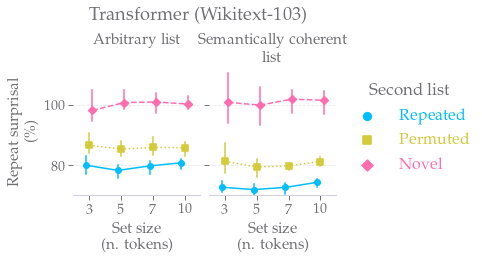

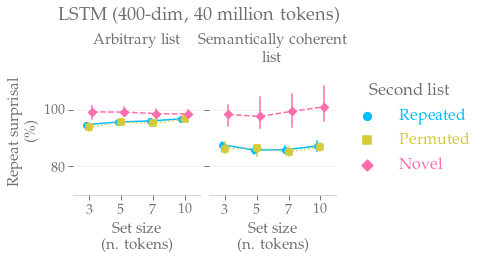

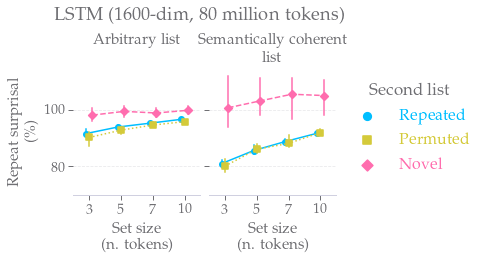

In [283]:
dfs = (dat_gpt40m_, dat_rnn_, dat_rnn2_)
suptitles = ("Transformer (Wikitext-103)", "LSTM (400-dim, 40 million tokens)", "LSTM (1600-dim, 80 million tokens)")
savetags = ("trf-w12", "lstm-a10", "lstm-a70")
ylims = ((70, None), (70, 115), (70, 115))
basename = "set-size"
scenario = "sce3"

for df, suptitle, ylim, tag in zip(dfs, suptitles, ylims, savetags):
    
    plot_size=(4, 3)
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="list_len", y="x_perc", hue="condition", style="condition",
                                     col="list", ylim=ylim,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.7)
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    plt.suptitle(suptitle)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
         # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size with intervening text of 4 tokens. ".format(suptitle) + \
                            "We report the percentage of list-averaged surprisal on second relative to first lists. Ranges are 95\% confidence intervals around "\
                            "the observed median (bootstrap estimate, $N^{resample}$ = 1000).")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# AWD-LSTM

## Load data intact context

In [78]:
awd_sce1 = pd.read_csv(os.path.join(data_dir, "output_awd-lstm-3_a-10_sce1.csv"), sep="\t", index_col=0)

for d in (awd_sce1,):
    d.rename(columns={"word": "token"}, inplace=True)
    d["model"] = "awd_lstm"

In [79]:
# show original and target lists for stimulus input 11
for dat in (awd_sce1,):
    
    sel = (dat.list_len==5) & (dat.prompt_len==8) & (dat.context=="intact") & (dat.list=="random") & (dat.second_list=="permute") & (dat.marker.isin([1, 3]))
    d = dat.loc[sel]
    stimid=11
    display("Original and target lists for stimulus {}:".format(stimid))
    display(d.loc[d.stimid==stimid, ["token", "marker", "model", "second_list"]])

'Original and target lists for stimulus 11:'

,token,marker,model,second_list
2301634,costume,1,awd_lstm,permute
2301635,pleasure,1,awd_lstm,permute
2301636,pattern,1,awd_lstm,permute
2301637,leader,1,awd_lstm,permute
2301638,culture,1,awd_lstm,permute
2301661,culture,3,awd_lstm,permute
2301662,pleasure,3,awd_lstm,permute
2301663,leader,3,awd_lstm,permute
2301664,costume,3,awd_lstm,permute
2301665,pattern,3,awd_lstm,permute


### Example timecourse

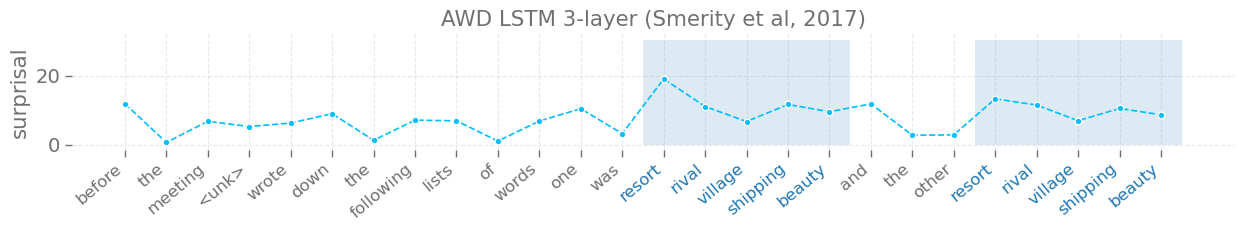

Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce3_awd_lstm-a-10.


In [68]:
ids = ("a-10",)
tags = ("awd_lstm",)
titles = ("AWD LSTM 3-layer (Smerity et al, 2017)",)
scenarios = ("sce3",)
contexts = ("short",)

for dat, model_id, tag, scenario, title, context in zip((awd_sce3,), ids, tags, scenarios, titles, contexts):

    f, a = make_example_plot(data=dat, seed=4321, model_id=model_id, context=context, ylim=(0, 30), title=title)
    
    plt.show()
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

### Prepare data

In [75]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["short"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_awd = None
awd_sce3_, _ = filter_and_aggregate(datain=awd_sce3, model="awd_lstm", model_id="a-10", groups=variables, aggregating_metric="mean")


[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

### Point plots

N per group == 230


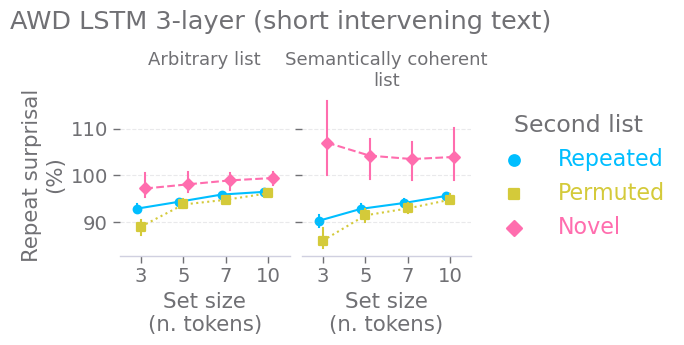

Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_awd-lstm.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_awd-lstm.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_awd-lstm.tex


In [76]:
dfs = (awd_sce3_,)
suptitles = ("AWD LSTM 3-layer (short intervening text)",)
savetags = ("awd-lstm",)
ylims = ((None, None),)
basename = "set-size"
scenario = "sce3"

for df, suptitle, ylim, tag in zip(dfs, suptitles, ylims, savetags):
    
    plot_size=(4, 3)
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="list_len", y="x_perc", hue="condition", style="condition",
                                     col="list", ylim=ylim,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(%)",
                                     suptitle=suptitle, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.7)
    ax[0].set_title("Arbitrary list\n", fontsize=13)
    ax[1].set_title("Semantically coherent\nlist", fontsize=13)
    plt.suptitle(suptitle)
    plt.show()
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
         # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size with intervening text of 4 tokens. ".format(suptitle) + \
                            "We report the percentage of list-averaged surprisal on second relative to first lists. Ranges are 95\% confidence intervals around "\
                            "the observed median (bootstrap estimate, $N^{resample}$ = 1000).")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Short intervening text

In [74]:
awd_sce3 = pd.read_csv(os.path.join(data_dir, "output_awd-lstm-3_a-10_sce3.csv"), sep="\t", index_col=0)

for d in (awd_sce3,):
    d.rename(columns={"word": "token"}, inplace=True)
    d["model"] = "awd_lstm"

In [67]:
# show original and target lists for stimulus input 11
for dat in (awd_sce3,):
    
    sel = (dat.list_len==5) & (dat.prompt_len==8) & (dat.context=="short") & (dat.list=="random") & (dat.second_list=="permute") & (dat.marker.isin([1, 3]))
    d = dat.loc[sel]
    stimid=11
    display("Original and target lists for stimulus {}:".format(stimid))
    display(d.loc[d.stimid==stimid, ["token", "marker", "model", "second_list"]])

'Original and target lists for stimulus 11:'

,token,marker,model,second_list
84019,costume,1,awd_lstm,permute
84020,pleasure,1,awd_lstm,permute
84021,pattern,1,awd_lstm,permute
84022,leader,1,awd_lstm,permute
84023,culture,1,awd_lstm,permute
84027,culture,3,awd_lstm,permute
84028,pleasure,3,awd_lstm,permute
84029,leader,3,awd_lstm,permute
84030,costume,3,awd_lstm,permute
84031,pattern,3,awd_lstm,permute


### Example timecourse

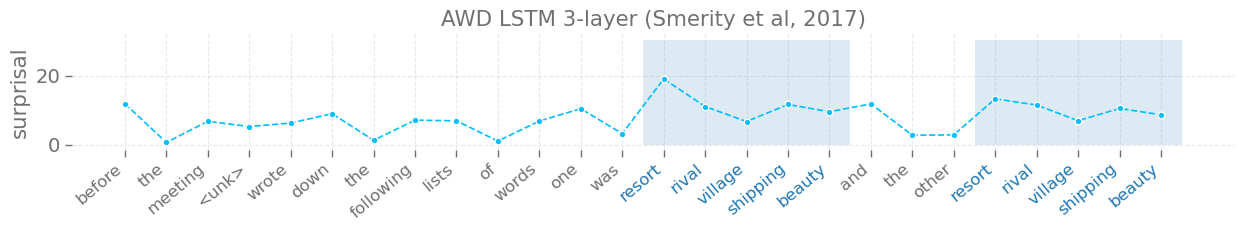

Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce3_awd_lstm-a-10.


In [68]:
ids = ("a-10",)
tags = ("awd_lstm",)
titles = ("AWD LSTM 3-layer (Smerity et al, 2017)",)
scenarios = ("sce3",)
contexts = ("short",)

for dat, model_id, tag, scenario, title, context in zip((awd_sce3,), ids, tags, scenarios, titles, contexts):

    f, a = make_example_plot(data=dat, seed=4321, model_id=model_id, context=context, ylim=(0, 30), title=title)
    
    plt.show()
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

### Prepare data

In [75]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["short"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_awd = None
awd_sce3_, _ = filter_and_aggregate(datain=awd_sce3, model="awd_lstm", model_id="a-10", groups=variables, aggregating_metric="mean")


[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

### Point plots

N per group == 230


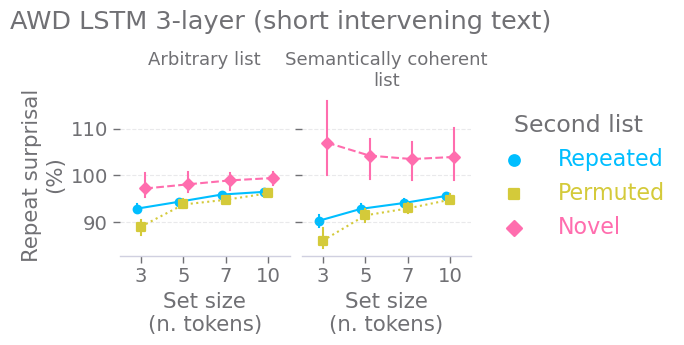

Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_awd-lstm.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_awd-lstm.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_awd-lstm.tex


In [76]:
dfs = (awd_sce3_,)
suptitles = ("AWD LSTM 3-layer (short intervening text)",)
savetags = ("awd-lstm",)
ylims = ((None, None),)
basename = "set-size"
scenario = "sce3"

for df, suptitle, ylim, tag in zip(dfs, suptitles, ylims, savetags):
    
    plot_size=(4, 3)
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="list_len", y="x_perc", hue="condition", style="condition",
                                     col="list", ylim=ylim,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(%)",
                                     suptitle=suptitle, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.7)
    ax[0].set_title("Arbitrary list\n", fontsize=13)
    ax[1].set_title("Semantically coherent\nlist", fontsize=13)
    plt.suptitle(suptitle)
    plt.show()
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
         # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size with intervening text of 4 tokens. ".format(suptitle) + \
                            "We report the percentage of list-averaged surprisal on second relative to first lists. Ranges are 95\% confidence intervals around "\
                            "the observed median (bootstrap estimate, $N^{resample}$ = 1000).")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Average timecourse plots

### Prepare data

In [83]:
data = awd_sce1

# rename some row variables for plotting
new_list_names = {"categorized": "semantic", "random": "arbitrary"}
data.list = data.list.map(new_list_names)

new_second_list_names = {"control": "novel", "repeat": "repeated", "permute": "permuted"}
data.second_list = data.second_list.map(new_second_list_names)

In [84]:
context_len = 8
list_len = 10
context = "intact"

sel = (data.prompt_len == context_len) & \
      (data.list_len == list_len) & \
      (data.list.isin(["semantic", "arbitrary"])) & \
      (data.context == context) & \
      (data.model_id.isin(["a-10"])) & \
      (data.marker.isin([2, 3])) & \
      (data.second_list.isin(["repeated", "permuted", "novel"])) &\
      (data.marker_pos_rel.isin(list(range(-4, 10))))

d = data.loc[sel].copy()

# name column manually
d.rename(columns={"list": "list structure", "second_list": "condition"}, inplace=True)
# capitalize row values
new_second_list_names = {"novel": "Novel", "repeated": "Repeated", "permuted": "Permuted"}
d.condition = d.condition.map(new_second_list_names)

### Plots

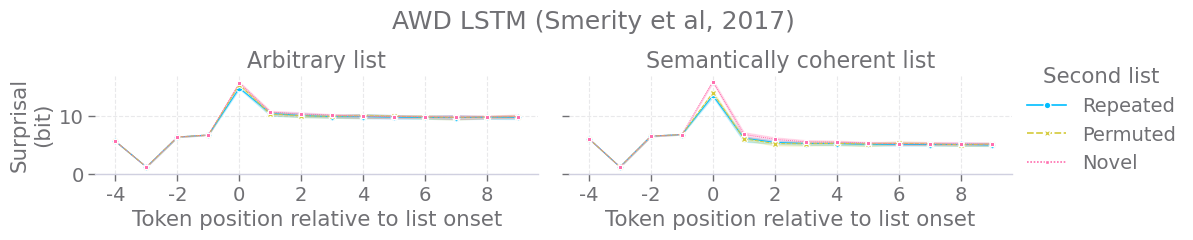

Saving \Users\karmeni1\project\lm-mem\fig\raw\timecourse_sce1_awd-lstm_a-10
Writing \Users\karmeni1\project\lm-mem\tables\revised\timecourse_sce1_awd-lstm_a-10_table.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\timecourse_sce1_awd-lstm_a-10_table.tex


In [95]:
# common fig properties
w, h = 12, 2

model_ids = ("a-10",)
tags = ("awd-lstm",)
titles = ("AWD LSTM (Smerity et al, 2017)",)
arcs = ("awd_lstm",)
ylims=((0, None),)
scenario = "sce1"

for model_id, suptitle, arc, tag, ylim in zip(model_ids, titles, arcs, tags, ylims):
    
    sel = ((d["model_id"] == model_id) & (d.model == arc))
    
    d.rename(columns={"marker_pos_rel": "marker-pos-rel", "condition": "Second list"}, inplace=True)
    
    p, ax, _ = make_timecourse_plot(d.loc[sel], x="marker-pos-rel", style="Second list", col="list structure",
                                    estimator=np.median,
                                    col_order=["arbitrary", "semantic"], err_style="band", 
                                    hue_order=["Repeated", "Permuted", "Novel"],
                                    style_order=["Repeated", "Permuted", "Novel"],
                                    xticks=list(range(-4, 10)))

    _, _, stat = make_timecourse_plot(d.loc[sel], x="marker-pos-rel", style="Second list", col="list structure", 
                                      estimator = np.median,
                                      col_order=["arbitrary", "semantic"], err_style="bars", 
                                      hue_order=["Repeated", "Permuted", "Novel"],
                                      style_order=["Repeated", "Permuted", "Novel"],
                                      xticks=list(range(-4, 10)))
    
    plt.close(plt.gcf())

    # set ylims
    ymin, ymax = ylim
    if ymin is None: ymin = ax[0].get_ylim()[0]
    if ymax is None: ymax = ax[0].get_ylim()[1]
    ax[0].set(ylim=(ymin, ymax))
    
    ax[0].set_title("Arbitrary list", fontsize=16)
    ax[1].set_title("Semantically coherent list", fontsize=16)
    ax[0].set_ylabel("Surprisal\n(bit)")
    for a in ax:
        a.set_xlabel("Token position relative to list onset")
        a.set_xticks(list(range(-4, 10, 2)))
        a.set_xticklabels(list(range(-4, 10, 2)))
            
    p.fig.suptitle(suptitle, fontsize=18)
    p.fig.set_size_inches(w=w, h=h)
    p.fig.subplots_adjust(top=0.65)

    plt.show()
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "timecourse_{}_{}_{}".format(scenario, tag, model_id))))
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.pdf".format(scenario, tag, model_id)), transparent=True, bbox_inches="tight")
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")
        
        # save numerical tables
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

            # save the original .csv
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.csv".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"list structure": "List", "marker-pos-rel": "Token position"}, inplace=True)
        tex = stat.loc[stat["Token position"].isin(list(range(0, 4))), :]\
                  .pivot(index=["List", "Second list"], columns=["Token position"], values="report_str")\
                  .to_latex(bold_rows=True,
                            label="tab:timecourse_{}_{}_{}".format(scenario, tag, model_id),
                            caption="{} surprisal values for four initial token positions, list type and second list condition.".format(suptitle))

        # now save as .tex file
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.tex".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Control results: ":" --> ","

In [365]:
data_gpt, data_40m, data_rnn = None, None, None
scenario = "sce5"
scenario_title = "Comma as cue"
data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_{}.csv".format(scenario)), sep="\t", index_col=0)
data_40m = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12_{}.csv".format(scenario)), sep="\t", index_col=0)

data_gpt["context"] = "no-comma"
data_40m["context"] = "no-comma"
data_gpt["model"] = "gpt-2"
data_40m["model"] = "gpt-2"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Example time course

Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce5_trf-a-10.
Saving \Users\karmeni1\project\lm-mem\fig\raw\example_sce5_trf-w-12.


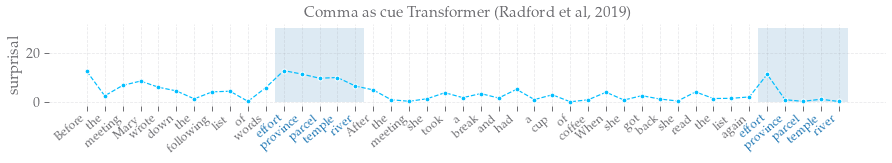

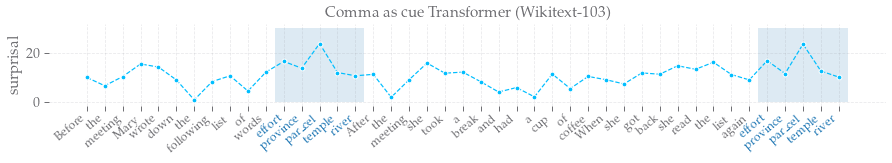

In [42]:
ids = ("a-10", "w-12")
tags = ("trf", "trf")
titles = ("Transformer (Radford et al, 2019)", "Transformer (Wikitext-103)")
scenario = "sce5"

for dat, model_id, tag, title in zip((data_gpt, data_40m), ids, tags, titles):

    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, context="no-comma", ylim=(0, 30), title="{} ".format(scenario_title) + title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

## Averaged timecourse plot

In [ ]:
data_gpt_time = select_data_for_timecourse(data=data_gpt, list_len=10, context_len=8, context="no-comma", model_tags=["a-10"], 
                                            timesteps=list(range(-4, 10)))

# rename some columns for latex fonts to work
data_gpt_time.rename(columns={"marker_pos_rel": "marker-pos-rel", "condition": "Second list"}, inplace=True)

# rename some row variables for plotting
new_list_names = {"categorized": "semantic", "random": "arbitrary"}
data_gpt_time.list = data_gpt_time.list.map(new_list_names)
# capitalize row values
new_second_list_names = {"control": "Novel", "repeat": "Repeated", "permute": "Permuted"}
data_gpt_time.second_list = data_gpt_time.second_list.map(new_second_list_names)
# name column manually
data_gpt_time.rename(columns={"list": "list structure", "second_list": "Second list"}, inplace=True)

In [ ]:
# common fig properties
w, h = 12, 2

p, ax, _ = make_timecourse_plot(data_gpt_time, x="marker-pos-rel", style="Second list", col="list structure", 
                                   col_order=["arbitrary", "semantic"], err_style="band", estimator=np.median,
                                   hue_order=["Repeated", "Permuted", "Novel"],
                                   style_order=["Repeated", "Permuted", "Novel"],
                                   xticks=list(range(-4, 10)))

_, _, stat = make_timecourse_plot(data_gpt_time, x="marker-pos-rel", style="Second list", col="list structure", 
                                  col_order=["arbitrary", "semantic"], err_style="bars", estimator=np.median,
                                  hue_order=["Repeated", "Permuted", "Novel"],
                                  style_order=["Repeated", "Permuted", "Novel"],
                                  xticks=list(range(-4, 10)))
plt.close(plt.gcf())

# set ylims
#ymin, ymax = (0, None)
#if ymin is None: ymin = ax[0].get_ylim()[0]
#if ymax is None: ymax = ax[0].get_ylim()[1]
#ax[0].set(ylim=(ymin, ymax))

ax[0].set_title("Arbitrary list", fontsize=16)
ax[1].set_title("Semantically coherent list", fontsize=16)
ax[0].set_ylabel("Surprisal\n(bit)")
for a in ax:
    a.set_xlabel("Token position relative to list onset")
    a.set_xticks(list(range(-4, 10, 2)))
    a.set_xticklabels(list(range(-4, 10, 2)))

p.fig.suptitle("{} Transformer (Radford et al, 2019)".format(scenario_title), fontsize=18)
p.fig.set_size_inches(w=w, h=h)
p.fig.subplots_adjust(top=0.65)

if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "timecourse_{}__{}_{}".format(scenario, tag, model_id))))
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.pdf".format(scenario, tag, model_id)), transparent=True, bbox_inches="tight")
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

            # save the original .csv
        fname = os.path.join(table_savedir, "timecourse_{}_{}_table.csv".format(tag, model_id))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"list structure": "List", "marker-pos-rel": "Token position"}, inplace=True)
        tex = stat.loc[stat["Token position"].isin(list(range(0, 4))), :]\
                  .pivot(index=["List", "Second list"], columns=["Token position"], values="report_str")\
                  .to_latex(bold_rows=True,
                            label="tab:timecourse_{}_{}_{}".format(scenario, tag, model_id),
                            caption="{} surprisal values for four initial token positions, list type and second list condition when ':' " + \
                                     "token is replaced by ',' in preface in prompt strings".format(suptitle))

        # now save as .tex file
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.tex".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Aggregate data

In [366]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["no-comma"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

## Point plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce5_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce5_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce5_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce5_trf-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce5_trf-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce5_trf-a10.tex


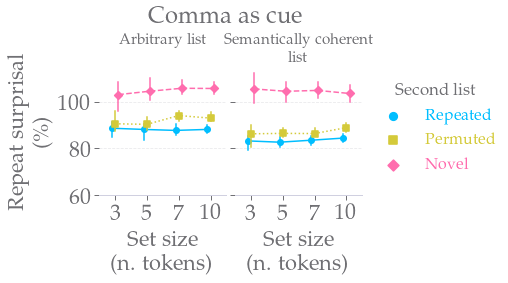

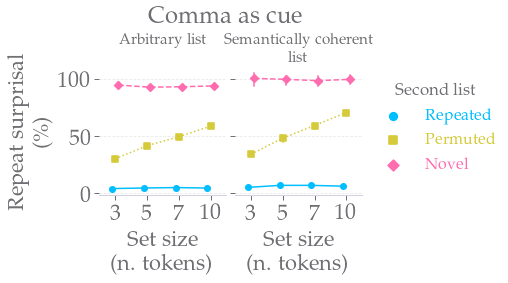

In [368]:
dfs = (dat_40m_, dat_gpt_)
suptitles = (f"{scenario_title}", f"{scenario_title}")
savetags = ("trf-w12", "trf-a10")
ylims=((60, 115), (None, None))
basename="set-size"
scenario = "sce5"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    grid, ax, stat = make_point_plot(data_frame=df, x="list_len", y="x_perc", hue="condition", style="condition", col="list", ylim=ylim,
                                     estimator=np.median,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, suptitle_fs=24, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()): 
            label.set_fontsize(22)
        a.set_xlabel(a.get_xlabel(), fontsize=22)

    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=22)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size when ':' token is replaced by ',' in preface in prompt strings ".format(suptitle) + \
                            "We report the percentage of list-averaged surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Bar plot

In [ ]:
variables = [{"marker_pos_rel": list(range(0, 3))},
             {"prompt_len": [8]},
             {"context": ["no-comma"]},
             {"list_len": [10]}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")

In [ ]:
dfs = (dat_40m_, dat_gpt_)
suptitles = ("{}\nTransformer (Wikitext-103)".format(scenario_title), "{}\nTransformer (Radford et al, 2019)".format(scenario_title))
savetags = ("trf-w12", "trf-a10")
ylims=((60, None), (None, None))
basename="per-token-bar"
scenario = "sce5"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    #grid, ax, stat = make_point_plot(data_frame=df, x="list_len", y="x_perc", hue="condition", col="list", ylim=ylim,
    #                              xlabel="set size\n(n. tokens)", ylabel="repeat surprisal\n(\%)",
    #                              suptitle=suptitle, scale=0.8,
    #                              legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
    #                              size_inches=plot_size)
    
    grid, ax, stat = make_bar_plot(data_frame=df, x="marker_pos_rel", y="x_perc", hue="condition", col="list", ylim=ylim,
                                   estimator=np.median,
                                   xlabel="Intervening text", ylabel="Repeat surprisal\n(\%)",
                                   suptitle=suptitle,
                                   legend=False, legend_out=True, legend_title="Second list",
                                   size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.60)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    for i in range(len(ax)):
        ax[i].set_xlabel("Token position\nin list")
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"condition": "Condition", "list": "List", "marker_pos_rel": "Token position\n relative to onset"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Token position\n relative to onset"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} relative surprisal as a function of token position relative to list onset when ':' token is replaced by ',' in preface in prompt strings ".format(suptitle) + \
                            "We report the percentage of list-median surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Control results: "Mary" --> "John"

In [369]:
data_gpt, data_40m, data_rnn = None, None, None
scenario = "sce6"a
scenario_txt = "'John' instead of 'Mary'"
data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_{}.csv".format(scenario)), sep="\t", index_col=0)
data_40m = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12_{}.csv".format(scenario)), sep="\t", index_col=0)

data_gpt["context"] = "mary-john"
data_40m["context"] = "mary-john"
data_gpt["model"] = "gpt-2"
data_40m["model"] = "gpt-2"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Example time course

In [ ]:
ids = ("a-10", "w-12")
tags = ("trf", "trf")
titles = ("{} (GPT-2)".format(scenario_txt), "{} Transformer (Wikitext-103)".format(scenario_txt))

for dat, model_id, tag, title in zip((data_gpt, data_40m), ids, tags, titles):

    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, context="mary-john", ylim=(0, 30), title=title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

## Averaged timecourse

In [ ]:
data_gpt_time = select_data_for_timecourse(data=data_gpt, list_len=10, context_len=8, context="mary-john", model_tags=["a-10"], 
                                            timesteps=list(range(-4, 10)))

# rename some columns for latex fonts to work
data_gpt_time.rename(columns={"marker_pos_rel": "marker-pos-rel", "condition": "Second list"}, inplace=True)

# rename some row variables for plotting
new_list_names = {"categorized": "semantic", "random": "arbitrary"}
data_gpt_time.list = data_gpt_time.list.map(new_list_names)
# capitalize row values
new_second_list_names = {"control": "Novel", "repeat": "Repeated", "permute": "Permuted"}
data_gpt_time.second_list = data_gpt_time.second_list.map(new_second_list_names)
# name column manually
data_gpt_time.rename(columns={"list": "list structure", "second_list": "Second list"}, inplace=True)

In [ ]:
p, ax, _ = make_timecourse_plot(data_gpt_time, x="marker-pos-rel", style="Second list", col="list structure", 
                                   col_order=["arbitrary", "semantic"], err_style="band", estimator=np.median,
                                   hue_order=["Repeated", "Permuted", "Novel"],
                                   style_order=["Repeated", "Permuted", "Novel"],
                                   xticks=list(range(-4, 10)))

_, _, stat = make_timecourse_plot(data_gpt_time, x="marker-pos-rel", style="Second list", col="list structure", 
                                  col_order=["arbitrary", "semantic"], err_style="bars", estimator=np.median,
                                  hue_order=["Repeated", "Permuted", "Novel"],
                                  style_order=["Repeated", "Permuted", "Novel"],
                                  xticks=list(range(-4, 10)))
plt.close(plt.gcf())

# set ylims
ymin, ymax = ylim
if ymin is None: ymin = ax[0].get_ylim()[0]
if ymax is None: ymax = ax[0].get_ylim()[1]
ax[0].set(ylim=(ymin, ymax))

ax[0].set_title("Arbitrary list", fontsize=16)
ax[1].set_title("Semantically coherent list", fontsize=16)
ax[0].set_ylabel("Surprisal\n(bit)")
for a in ax:
    a.set_xlabel("Token position relative to list onset")
    a.set_xticks(list(range(-4, 10, 2)))
    a.set_xticklabels(list(range(-4, 10, 2)))

p.fig.suptitle("{} Transformer (Radford et al, 2019)".format(scenario_txt), fontsize=18)
p.fig.set_size_inches(w=w, h=h)
p.fig.subplots_adjust(top=0.65)


if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "timecourse_{}__{}_{}".format(scenario, tag, model_id))))
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.pdf".format(scenario, tag, model_id)), transparent=True, bbox_inches="tight")
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

            # save the original .csv
        fname = os.path.join(table_savedir, "timecourse_{}_{}_table.csv".format(tag, model_id))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"list structure": "List", "marker-pos-rel": "Token position"}, inplace=True)
        tex = stat.loc[stat["Token position"].isin(list(range(0, 4))), :]\
                  .pivot(index=["List", "Second list"], columns=["Token position"], values="report_str")\
                  .to_latex(bold_rows=True,
                            label="tab:timecourse_{}_{}_{}".format(scenario, tag, model_id),
                            caption="{} surprisal values for four initial token positions, list type and second list condition when ':' " + \
                                     "token is replaced by ',' in preface in prompt strings".format(suptitle))

        # now save as .tex file
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.tex".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Aggregate data

In [370]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["mary-john"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

## Point plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce6_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce6_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce6_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce6_trf-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce6_trf-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce6_trf-a10.tex


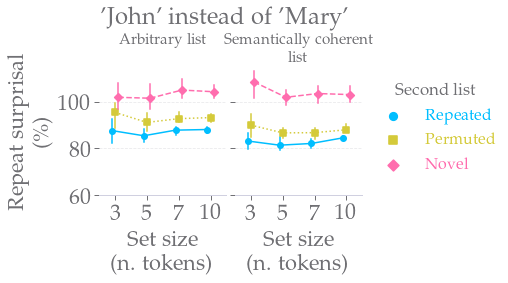

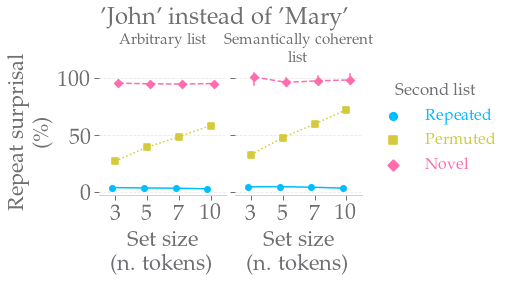

In [371]:
dfs = (dat_40m_, dat_gpt_)
suptitles = (f"{scenario_txt}", f"{scenario_txt}")
savetags = ("trf-w12", "trf-a10")
ylims=((60, 115), (None, None))
basename="set-size"
scenario="sce6"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    grid, ax, stat = make_point_plot(data_frame=df, x="list_len", y="x_perc", hue="condition", style="condition", col="list", ylim=ylim,
                                     estimator=np.median,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, suptitle_fs=24, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    tick_fs, label_fs = 22, 22
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()): 
            label.set_fontsize(tick_fs)
        a.set_xlabel(a.get_xlabel(), fontsize=label_fs)
    
    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=label_fs)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size when 'Mary' is replaced with 'John'. We report the percentage of ".format(suptitle) + \
                            "list-averaged surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Aggregated data: bar plot

In [ ]:
variables = [{"marker_pos_rel": list(range(0, 3))},
             {"prompt_len": [8]},
             {"context": ["mary-john"]},
             {"list_len": [10]}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")

In [ ]:
dfs = (dat_40m_, dat_gpt_)
suptitles = ("{}\nTransformer (Wikitext-103)".format(scenario_txt), "{}\nTransformer (Radford et al, 2019)".format(scenario_txt))
savetags = ("trf-w12", "trf-a10")
ylims=((60, None), (None, None))
basename="per-token-bar"
scenario = "sce6"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    #grid, ax, stat = make_point_plot(data_frame=df, x="list_len", y="x_perc", hue="condition", col="list", ylim=ylim,
    #                              xlabel="set size\n(n. tokens)", ylabel="repeat surprisal\n(\%)",
    #                              suptitle=suptitle, scale=0.8,
    #                              legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
    #                              size_inches=plot_size)
    
    grid, ax, stat = make_bar_plot(data_frame=df, estimator=np.median, x="marker_pos_rel", y="x_perc", hue="condition", col="list", ylim=ylim,
                              xlabel="Intervening text", ylabel="Repeat surprisal\n(\%)",
                              suptitle=suptitle,
                              legend=False, legend_out=True, legend_title="Second list",
                              size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.60)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    for i in range(len(ax)):
        ax[i].set_xlabel("Token position\nin list")
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"condition": "Condition", "list": "List", "marker_pos_rel": "Token position\n relative to onset"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Token position\n relative to onset"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of token position relative to list onset when 'Mary' is replaced by 'John' in preface prompt strings ".format(suptitle) + \
                            "We report the percentage of surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed group median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Randomly permuted preface string

In [372]:
data_gpt, data_40m, data_rnn = None, None, None
scenario = "sce4"
scenario_txt = "Shuffled preface string"
data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_{}.csv".format(scenario)), sep="\t", index_col=0)
data_40m = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12_{}.csv".format(scenario)), sep="\t", index_col=0)

data_gpt["context"] = "shuf-preface"
data_40m["context"] = "shuf-preface"
data_gpt["model"] = "gpt-2"
data_40m["model"] = "gpt-2"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Example time course

In [ ]:
ids = ("a-10", "w-12")
tags = ("trf", "trf")
titles = ("{}\nTransformer (Radford et al, 2019)".format(scenario_txt), "{}\nTransformer (Wikitext-103)".format(scenario_txt))
scenario = "sce4"

for dat, model_id, tag, title in zip((data_gpt, data_40m), ids, tags, titles):

    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, context="shuf-preface", ylim=(0, 30), title=title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

## Averaged timecourse

In [ ]:
data_gpt_time = select_data_for_timecourse(data=data_gpt, list_len=10, context_len=8, context="shuf-preface", model_tags=["a-10"], 
                                            timesteps=list(range(-4, 10)))

# rename some columns for latex fonts to work
data_gpt_time.rename(columns={"marker_pos_rel": "marker-pos-rel", "condition": "Second list"}, inplace=True)

# rename some row variables for plotting
new_list_names = {"categorized": "semantic", "random": "arbitrary"}
data_gpt_time.list = data_gpt_time.list.map(new_list_names)
# capitalize row values
new_second_list_names = {"control": "Novel", "repeat": "Repeated", "permute": "Permuted"}
data_gpt_time.second_list = data_gpt_time.second_list.map(new_second_list_names)
# name column manually
data_gpt_time.rename(columns={"list": "list structure", "second_list": "Second list"}, inplace=True)

In [ ]:
p, ax, _ = make_timecourse_plot(data_gpt_time, x="marker-pos-rel", style="Second list", col="list structure", 
                                col_order=["arbitrary", "semantic"], err_style="band", estimator=np.median,
                                hue_order=["Repeated", "Permuted", "Novel"],
                                style_order=["Repeated", "Permuted", "Novel"],
                                xticks=list(range(-4, 10)))

_, _, stat = make_timecourse_plot(d.loc[sel], x="marker-pos-rel", style="Second list", col="list structure", 
                                  col_order=["arbitrary", "semantic"], err_style="bars", estimator=np.median,
                                  hue_order=["Repeated", "Permuted", "Novel"],
                                  style_order=["Repeated", "Permuted", "Novel"],
                                  xticks=list(range(-4, 10)))
plt.close(plt.gcf())

# set ylims
ymin, ymax = ylim
if ymin is None: ymin = ax[0].get_ylim()[0]
if ymax is None: ymax = ax[0].get_ylim()[1]
ax[0].set(ylim=(ymin, ymax))

ax[0].set_title("Arbitrary list", fontsize=16)
ax[1].set_title("Semantically coherent list", fontsize=16)
ax[0].set_ylabel("Surprisal\n(bit)")
for a in ax:
    a.set_xlabel("Token position relative to list onset")
    a.set_xticks(list(range(-4, 10, 2)))
    a.set_xticklabels(list(range(-4, 10, 2)))

p.fig.suptitle("{} Transformer (Radford et al, 2019)".format(scenario_txt), fontsize=18)
p.fig.set_size_inches(w=w, h=h)
p.fig.subplots_adjust(top=0.65)
        
if savefigs:

    print("Saving {}".format(os.path.join(savedir, "timecourse_{}__{}_{}".format(scenario, tag, model_id))))
    p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.pdf".format(scenario, tag, model_id)), transparent=True, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

    # create a column with string formated and save the table as well
    stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
    strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
    stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
    fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.csv".format(scenario, tag, model_id))
    print("Writing {}".format(fname))
    stat.to_csv(fname)

    # save for latex
    stat.rename(columns={"list structure": "List", "marker-pos-rel": "Token position"}, inplace=True)
    tex = stat.loc[stat["Token position"].isin(list(range(0, 4))), :]\
              .pivot(index=["List", "Second list"], columns=["Token position"], values="report_str")\
              .to_latex(bold_rows=True,
                        label="tab:timecourse_{}_{}_{}.".format(scenario, tag, model_id),
                        caption="{} surprisal values for four initial token positions, list type and second list condition when tokens in preface string" + \
                                 "are randomly permuted".format(suptitle))

    # now save as .tex file
    fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.tex".format(scenario, tag, model_id))
    print("Writing {}".format(fname))
    with open(fname, "w") as f:
        f.writelines(tex)

## Aggregate data

In [373]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["shuf-preface"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

## Point plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce4_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce4_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce4_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce4_trf-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce4_trf-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce4_trf-a10.tex


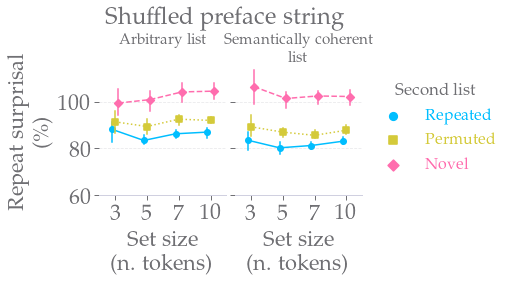

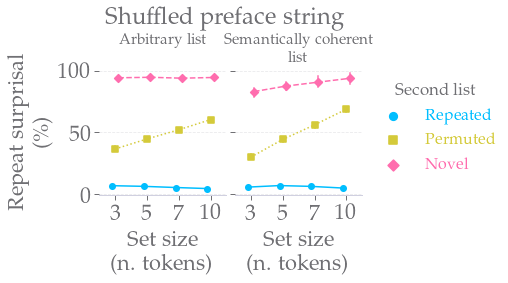

In [374]:
dfs = (dat_40m_, dat_gpt_)
suptitles = (f"{scenario_txt}", f"{scenario_txt}")
savetags = ("trf-w12", "trf-a10")
ylims=((60, 115), (None, None))
basename="set-size"
scenario = "sce4"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="list_len", y="x_perc", hue="condition", style="condition",
                                     col="list", ylim=ylim,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, suptitle_fs=24, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    tick_fs, label_fs = 22, 22
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()): 
            label.set_fontsize(tick_fs)
        a.set_xlabel(a.get_xlabel(), fontsize=label_fs)
    
    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=label_fs)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size when tokens in preface string are randomly permuted. We report the percentage of ".format(suptitle) + \
                            "list-median surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Per-token bar plot

In [ ]:
variables = [{"marker_pos_rel": list(range(0, 3))},
             {"prompt_len": [8]},
             {"context": ["shuf-preface"]},
             {"list_len": [10]}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")

In [ ]:
dfs = (dat_40m_, dat_gpt_)
suptitles = ("{}\nTransformer (Wikitext-103)".format(scenario_txt), "{}\nTransformer (Radford et al, 2019)".format(scenario_txt))
savetags = ("trf-w12", "trf-a10")
ylims=((60, None), (None, None))
basename="per-token-bar"
scenario = "sce4"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    #grid, ax, stat = make_point_plot(data_frame=df, x="list_len", y="x_perc", hue="condition", col="list", ylim=ylim,
    #                              xlabel="set size\n(n. tokens)", ylabel="repeat surprisal\n(\%)",
    #                              suptitle=suptitle, scale=0.8,
    #                              legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
    #                              size_inches=plot_size)
    
    grid, ax, stat = make_bar_plot(data_frame=df, x="marker_pos_rel", y="x_perc", hue="condition", col="list", ylim=ylim,
                              xlabel="intervening text", ylabel="repeat surprisal\n(\%)",
                              suptitle=suptitle,
                              legend=False, legend_out=True, legend_title="Second list",
                              size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.60)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    for i in range(len(ax)):
        ax[i].set_xlabel("token position\nin list")
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"condition": "Condition", "list": "List", "marker_pos_rel": "Token position\nrelative to onset"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Token position\nrelative to onset"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of token position when preface string is randomly shuffled ".format(suptitle) + \
                            "We report surprisal on second relative to first lists as percentage. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Randomly permuted prompt string

In [375]:
data_gpt, data_40m, data_rnn = None, None, None
scenario = "sce7"
scenario_txt = "Shuffled prompt string"
data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_{}.csv".format(scenario)), sep="\t", index_col=0)
data_40m = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12_{}.csv".format(scenario)), sep="\t", index_col=0)

data_gpt["context"] = "shuf-prompt"
data_40m["context"] = "shuf-prompt"
data_gpt["model"] = "gpt-2"
data_40m["model"] = "gpt-2"

C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Example time course

In [ ]:
ids = ("a-10", "w-12")
tags = ("trf", "trf")
titles = ("{}\nTransformer (Radford et al, 2019)".format(scenario_txt), "{}\nTransformer (Wikitext-103)".format(scenario_txt))
scenario = "sce7"

for dat, model_id, tag, title in zip((data_gpt, data_40m), ids, tags, titles):

    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, context="shuf-prompt", ylim=(0, 30), title=title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

## Averaged timecourse (Radford et al, 2019)

In [ ]:
tmp = []
for dat, model_tag in zip((data_gpt, data_40m), ("a-10", "w-12")):
    
    tmp_df_time = select_data_for_timecourse(data=dat, list_len=10, context_len=8, context="shuf-prompt", model_tags=[model_tag], 
                                                timesteps=list(range(-4, 10)))

    # rename some columns for latex fonts to work
    tmp_df_time.rename(columns={"marker_pos_rel": "marker-pos-rel", "condition": "Second list"}, inplace=True)

    # rename some row variables for plotting
    new_list_names = {"categorized": "semantic", "random": "arbitrary"}
    tmp_df_time.list = tmp_df_time.list.map(new_list_names)
    # capitalize row values
    new_second_list_names = {"control": "Novel", "repeat": "Repeated", "permute": "Permuted"}
    tmp_df_time.second_list = tmp_df_time.second_list.map(new_second_list_names)
    # name column manually
    tmp_df_time.rename(columns={"list": "list structure", "second_list": "Second list"}, inplace=True)
    
    tmp.append(tmp_df_time)
    
data_gpt_time, data_40m_time = tmp

In [ ]:
ids = ("a-10", "w-12")
tags = ("trf", "trf")
scenario = "sce7"
scenario_txt = "Shuffled prompt string"
titles = ("{} (Radford et al, 2019)".format(scenario_txt), "{} (Wikitext-103 transformer)".format(scenario_txt))

for dat, model_id, tag, title in zip((data_gpt_time, data_40m_time), ids, tags, titles):

    p, ax, _ = make_timecourse_plot(dat, estimator=np.median, x="marker-pos-rel", style="Second list", col="list structure", 
                                       col_order=["arbitrary", "semantic"], err_style="band", 
                                       hue_order=["Repeated", "Permuted", "Novel"],
                                       style_order=["Repeated", "Permuted", "Novel"],
                                       xticks=list(range(-4, 10)))

    _, _, stat = make_timecourse_plot(dat, estimator=np.median, x="marker-pos-rel", style="Second list", col="list structure", 
                                      col_order=["arbitrary", "semantic"], err_style="bars", 
                                      hue_order=["Repeated", "Permuted", "Novel"],
                                      style_order=["Repeated", "Permuted", "Novel"],
                                      xticks=list(range(-4, 10)))
    plt.close(plt.gcf())

    # set ylims
    ymin, ymax = 0, None
    if ymin is None: ymin = ax[0].get_ylim()[0]
    if ymax is None: ymax = ax[0].get_ylim()[1]
    ax[0].set(ylim=(ymin, ymax))

    ax[0].set_title("Arbitrary list", fontsize=16)
    ax[1].set_title("Semantically coherent list", fontsize=16)
    ax[0].set_ylabel("Surprisal\n(bit)")
    for a in ax:
        a.set_xlabel("Token position relative to list onset")
        a.set_xticks(list(range(-4, 10, 2)))
        a.set_xticklabels(list(range(-4, 10, 2)))

    w, h = 12, 2
    p.fig.suptitle(title, fontsize=18)
    p.fig.set_size_inches(w=w, h=h)
    p.fig.subplots_adjust(top=0.65)

    if savefigs:

        print("Saving {}".format(os.path.join(savedir, "timecourse_{}_{}_{}".format(scenario, tag, model_id))))
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.pdf".format(scenario, tag, model_id)), transparent=True, bbox_inches="tight")
        p.savefig(os.path.join(savedir, "timecourse_{}_{}_{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "median": 1})
        strfunc = lambda x: str(x["median"]) + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

            # save the original .csv
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.csv".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"list structure": "List", "marker-pos-rel": "Token position"}, inplace=True)
        tex = stat.loc[stat["Token position"].isin(list(range(0, 4))), :]\
                  .pivot(index=["List", "Second list"], columns=["Token position"], values="report_str")\
                  .to_latex(bold_rows=True,
                            label="tab:timecourse_{}_{}_{}.".format(scenario, tag, model_id),
                            caption="{} surprisal values for four initial token positions, list type and second list condition when tokens in preface string" + \
                                     "are randomly permuted".format(suptitle))

        # now save as .tex file
        fname = os.path.join(table_savedir, "timecourse_{}_{}_{}_table.tex".format(scenario, tag, model_id))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

## Aggregated data

In [376]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["shuf-prompt"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

## Point plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce7_trf-w12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce7_trf-w12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce7_trf-w12.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce7_trf-a10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce7_trf-a10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce7_trf-a10.tex


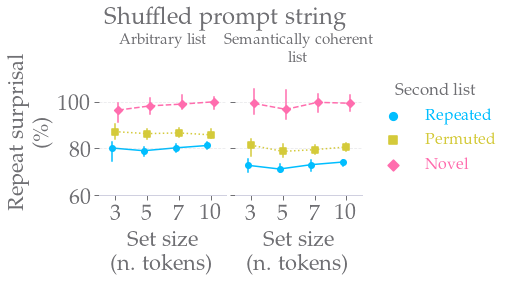

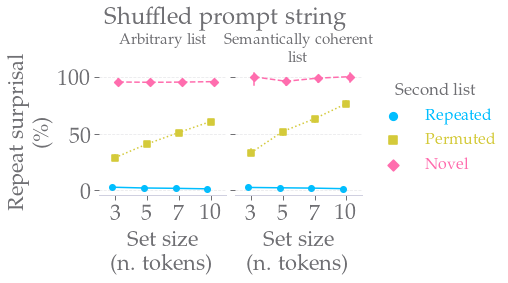

In [378]:
dfs = (dat_40m_, dat_gpt_)
suptitles = (f"{scenario_txt}", f"{scenario_txt}")
savetags = ("trf-w12", "trf-a10")
ylims=((60, 115), (None, None))
basename="set-size"
scenario = "sce7"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="list_len", y="x_perc", hue="condition", style="condition",
                                     col="list", ylim=ylim,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, suptitle_fs=24, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    tick_fs, label_fs = 22, 22
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()): 
            label.set_fontsize(tick_fs)
        a.set_xlabel(a.get_xlabel(), fontsize=label_fs)
    
    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=label_fs)

            
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size when tokens in prompt string are randomly permuted. We report the percentage of ".format(suptitle) + \
                            "list-median surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Control: median vs. mean

## Get data

In [ ]:
data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_sce1.csv"), sep="\t", index_col=0)
data_40m = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12_sce1.csv"), sep="\t", index_col=0)

data_rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_sce1.csv"), sep="\t", index_col=None)
data_rnn2 = pd.read_csv(os.path.join(data_dir, "output_rnn-vs2019_a-70_sce1.csv"), sep="\t", index_col=None)

data_rnn.rename(columns={"word": "token"}, inplace=True)
data_rnn2.rename(columns={"word": "token"}, inplace=True)
data_rnn["model"] = "lstm"
data_rnn2["model"] = "lstm"

data_gpt["model"] = "gpt-2"
data_40m["model"] = "gpt-2"

In [ ]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["intact"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_40m_, _ = filter_and_aggregate(datain=data_40m, model="gpt-2", model_id="w-12", groups=variables, aggregating_metric="mean")
dat_gpt_, _ = filter_and_aggregate(datain=data_gpt, model="gpt-2", model_id="a-10", groups=variables, aggregating_metric="mean")
dat_rnn_, _ = filter_and_aggregate(datain=data_rnn, model="lstm", model_id="a-10", groups=variables, aggregating_metric="mean")

## Plot

In [ ]:
dfs = (dat_40m_, dat_gpt_, dat_rnn_)
suptitles = ("Transformer (Wikitext-103)", "Transformer (Radford et al, 2019)", "LSTM (Wikitext-103)")
savetags = ("trf-w12", "trf-a10", "lstm-a10")
ylims=((60, 115), (None, None), (80, 120))
basename="set-size-mean-est"
scenario = "sce1"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.mean, x="list_len", y="x_perc", hue="condition", col="list", ylim=ylim,
                                      xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                      suptitle=suptitle, scale=0.8,
                                      legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                      size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size. We report the percentage of ".format(suptitle) + \
                            "list-median surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Null models (random init, shuffled attention)

In [379]:
gptlst = []
model_ids = ["r-10", "r-20", "r-25", "r-30"]

for model_id in model_ids:
    
    logging.info("Loading {}".format(os.path.join(data_dir, "output_gpt2_{}_sce1.csv".format(model_id))))
    tmp = pd.read_csv(os.path.join(data_dir, "output_gpt2_{}_sce1.csv".format(model_id)), sep="\t", index_col=0)
    tmp["model"] = "gpt-2"
    gptlst.append(tmp)

[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_r-10_sce1.csv
C:\Users\karmeni1\Miniconda3\envs\ptorch1.6\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_r-20_sce1.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_r-25_sce1.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_r-30_sce1.csv


## Example timecourses

In [ ]:
tags = ("trf", "trf", "trf", "trf")
titles = ("Transformer (random init.)", 
          "Transformer (shuffled attn. weights across heads)", 
          "Transformer (shuffled attn. weights per head)",
          "Transformer (shuffled position embed.)")

scenario = "sce1"

for dat, model_id, tag, title in zip(gptlst, model_ids, tags, titles):

    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, context="intact", ylim=(0, 30), title=title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

## Main plot

In [380]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["intact"]},
             {"marker_pos_rel": list(range(1, 10))}]

gptrnd_r10, _ = filter_and_aggregate(datain=gptlst[0], model="gpt-2", model_id="r-10", groups=variables, aggregating_metric="mean")
gptrnd_r20, _ = filter_and_aggregate(datain=gptlst[1], model="gpt-2", model_id="r-20", groups=variables, aggregating_metric="mean")
gptrnd_r25, _ = filter_and_aggregate(datain=gptlst[2], model="gpt-2", model_id="r-25", groups=variables, aggregating_metric="mean")
gptrnd_r30, _ = filter_and_aggregate(datain=gptlst[3], model="gpt-2", model_id="r-30", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce1_trf-r-10.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-10.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-10.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce1_trf-r-20.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-20.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-20.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce1_trf-r-25.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-25.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-25.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce1_trf-r-30.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-30.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce1_trf-r-30.

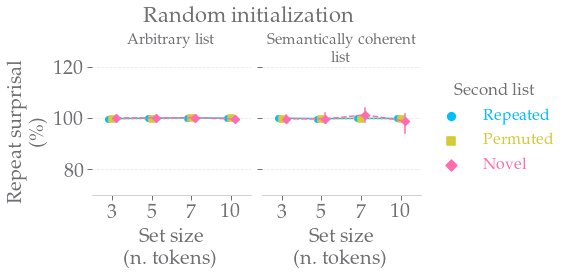

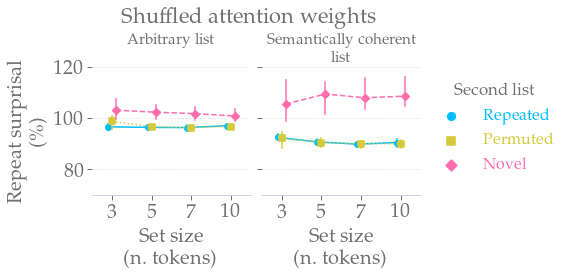

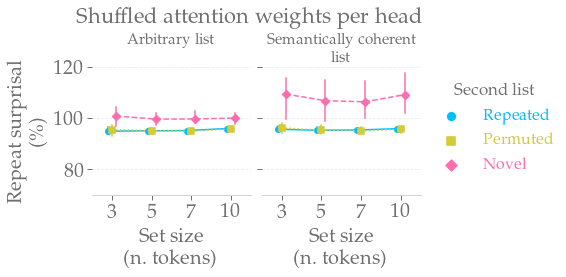

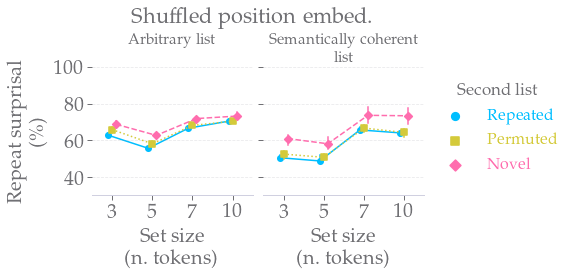

In [384]:
scenario = "sce1"
dfs = (gptrnd_r10, gptrnd_r20, gptrnd_r25, gptrnd_r30)
suptitles = ("Random initialization", 
             "Shuffled attention weights", 
             "Shuffled attention weights per head",
             "Shuffled position embed.")
savetags = ("trf", "trf", "trf", "trf")
ylims = ((70, 120), (70, 120), (70, 120), (30, 100))

basename = "set-size"

for df, suptitle, ylim, model_id, tag in zip(dfs, suptitles, ylims, model_ids, savetags):
    
    plot_size=(5, 3)
    grid, ax, stat = make_point_plot(data_frame=df, x="list_len", y="x_perc", hue="condition", style="condition", col="list", ylim=ylim,
                                     estimator=np.median,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, suptitle_fs=22, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    tick_fs, label_fs = 20, 20
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()): 
            label.set_fontsize(tick_fs)
        a.set_xlabel(a.get_xlabel(), fontsize=label_fs)
    
    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=label_fs)
    
    if savefigs:
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}-{}.".format(basename, scenario, tag, model_id))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}-{}.pdf".format(basename, scenario, tag, model_id)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}-{}.png".format(basename, scenario, tag, model_id)), dpi=300, bbox_inches="tight")
        
         # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}-{}.csv".format(basename, scenario, tag, model_id))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        tex = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")\
                  .to_latex(bold_rows=True,
                            label="{}_{}_{}-{}".format(basename, scenario, tag, model_id),
                            caption="{} word list surprisal as a function of set size. We report the percentage of ".format(suptitle) + \
                            "list-median surprisal on second relative to first lists. Ranges are 95\% confidence intervals around "\
                            "the observed median (bootstrap estimate ($N^{resample} = 1000$)."\
                            "Intervening text size is fixed at 26 tokens")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}-{}.tex".format(basename, scenario, tag, model_id))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Transformer and depth

In [385]:
model_ids = ["w-01", "w-03", "w-06", "w-12"]
scenario = "sce3"

dfs = []
for model_id in model_ids:
    
    logging.info("Loading {}".format(os.path.join(data_dir, "output_gpt2_{}_sce3.csv".format(model_id))))
    tmp = pd.read_csv(os.path.join(data_dir, "output_gpt2_{}_sce3.csv".format(model_id)), sep="\t", index_col=None)
    tmp["model"] = "gpt-2"
    dfs.append(tmp)

[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_w-01_sce3.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_w-03_sce3.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_w-06_sce3.csv
[INFO] Loading \Users\karmeni1\project\lm-mem\data\outputs\output_gpt2_w-12_sce3.csv


## Plot example trial

In [ ]:
tags = ("trf", "trf", "trf", "trf", "trf")
titles = ("Transformer (1 layer)", 
          "Transformer (3 layer)", 
          "Transformer (6 layer)",
          "Transformer (12 layer)")

for dat, model_id, tag, title in zip(dfs, model_ids, tags, titles):
    
    f, a = make_example_plot(data=dat, seed=123, model_id=model_id, context="short", ylim=(0, 30), title=title)
    
    if savefigs:
        
        # common fig properties
        print("Saving {}".format(os.path.join(savedir, "example_{}_{}-{}.".format(scenario, tag, model_id))))
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.pdf".format(scenario, tag, model_id)), transparent=True, dpi=300, bbox_inches="tight")
        f.savefig(os.path.join(savedir, "example_{}_{}-{}.png".format(scenario, tag, model_id)), dpi=300, bbox_inches="tight")

## Aggregate data

In [386]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["short"]},
             {"marker_pos_rel": list(range(1, 10))}]

dfs_ = []
for i, model_id in enumerate(model_ids):
    
    tmp, _ = filter_and_aggregate(datain=dfs[i], model="gpt-2", model_id=model_id, groups=variables, aggregating_metric="mean")
    dfs_.append(tmp)

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

## Point plot

N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_trf-w-01.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-01.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-01.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_trf-w-03.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-03.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-03.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_trf-w-06.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-06.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-06.tex
N per group == 230
Saving \Users\karmeni1\project\lm-mem\fig\raw\set-size_sce3_trf-w-12.
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-12.csv
Writing \Users\karmeni1\project\lm-mem\tables\revised\set-size_sce3_trf-w-12.

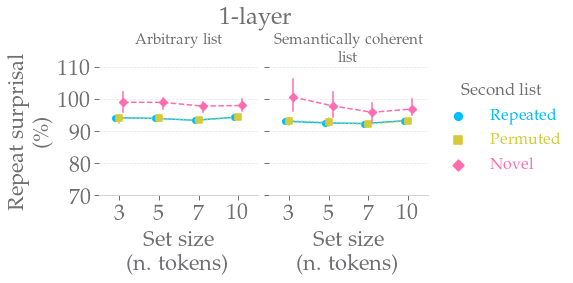

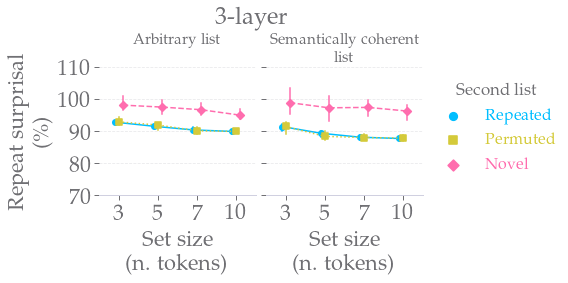

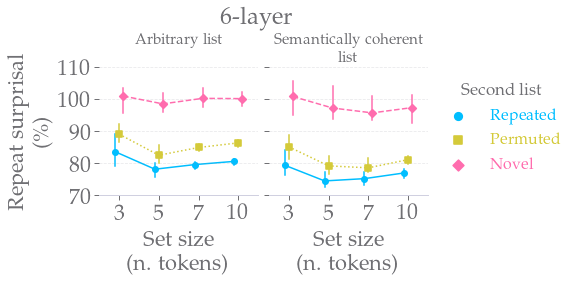

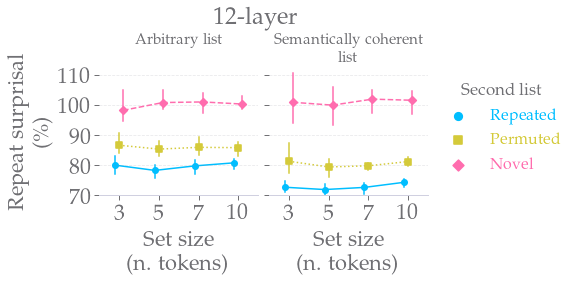

In [389]:
scenario = "sce3"
savetags = ("trf", "trf", "trf", "trf")
ylims = ((70, None), (70, None), (70, None), (70, None))
titles = ("1-layer", 
          "3-layer", 
          "6-layer",
          "12-layer")

basename = "set-size"

for df, suptitle, ylim, model_id, tag in zip(tuple(dfs_), titles, ylims, model_ids, savetags):
    
    plot_size=(5, 3)
    grid, ax, stat = make_point_plot(data_frame=df, estimator=np.median, x="list_len", y="x_perc", hue="condition", style="condition",
                                     col="list", ylim=ylim,
                                     xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                     suptitle=suptitle, suptitle_fs=24, scale=1, errwidth=1.5,
                                     legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                     size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    
    plt.suptitle(suptitle, fontsize=24)

    # handle yticks and labels
    ax[0].set_yticks(list(range(ylim[0], 120, 10)))
    ax[1].set_yticks(list(range(ylim[0], 120, 10)))
    ax[0].set_yticklabels(list(range(ylim[0], 120, 10)))
        
    tick_fs, label_fs = 22, 22
    for a in ax:
        for label in (a.get_xticklabels() + a.get_yticklabels()): 
            label.set_fontsize(tick_fs)
        a.set_xlabel(a.get_xlabel(), fontsize=label_fs)
    
    ax[0].set_ylabel("Repeat surprisal\n(\%)", fontsize=label_fs)
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}-{}.".format(basename, scenario, tag, model_id))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}-{}.pdf".format(basename, scenario, tag, model_id)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}-{}.png".format(basename, scenario, tag, model_id)), dpi=300, bbox_inches="tight")
        
         # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}-{}.csv".format(basename, scenario, tag, model_id))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        
        tex = stat.to_latex(bold_rows=True,
                            label="{}_{}_{}-{}.tex".format(basename, scenario, tag, model_id),
                            caption="{} word list surprisal as a function of set size. We report the percentage of ".format(suptitle) + \
                            "list-averaged surprisal on second relative to first lists. Ranges are 95\% confidence intervals around "\
                            "the observed median (bootstrap estimate).")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}-{}.tex".format(basename, scenario, tag, model_id))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Bert

## Prepare data

In [47]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["intact"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_bert_, _ = filter_and_aggregate(datain=data_bert, model="bert", model_id="b-10", groups=variables, aggregating_metric="mean")

[INFO] Aggregating metric == mean
[INFO] Aggregating over these variables:


['list_len', 'stimid', 'model', 'marker', 'list', 'second_list']

DataError: No numeric types to aggregate

# Additional transformer checkpoints

In [ ]:
data_gptB = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12b_sce1.csv"), sep="\t", index_col=0)
data_gptC = pd.read_csv(os.path.join(data_dir, "output_gpt2_w-12c_sce1.csv"), sep="\t", index_col=0)

data_gptB["model"] = "gpt-2"
data_gptC["model"] = "gpt-2"

## Data check

In [ ]:
# show original and target lists for stimulus input 11
for dat in (data_gptB, data_gptC):
    
    sel = (dat.list_len==5) & (dat.prompt_len==8) & (dat.context=="intact") & (dat.list=="random") & (dat.second_list=="permute") & (dat.marker.isin([1, 3]))
    d = dat.loc[sel]
    stimid=11
    display("Original and target lists for stimulus {}:".format(stimid))
    display(d.loc[d.stimid==stimid, ["token", "marker", "model", "second_list"]])

## Prepare data

In [ ]:
variables = [{"list_len": [3, 5, 7, 10]},
             {"prompt_len": [8]},
             {"context": ["intact"]},
             {"marker_pos_rel": list(range(1, 10))}]

dat_gptB_, _ = filter_and_aggregate(datain=data_gptB, model="gpt-2", model_id="w-12b", groups=variables, aggregating_metric="mean")
dat_gptC_, _ = filter_and_aggregate(datain=data_gptC, model="gpt-2", model_id="w-12c", groups=variables, aggregating_metric="mean")

## Plot

In [ ]:
dfs = (dat_gptB_, dat_gptC_)
suptitles = ("Transformer (Wikitext-103) B", "Transformer (Wikitext-103) C")
savetags = ("trf-w12b", "trf-w12c")
ylims=((70, 115), (70, 115))
basename = "set-size"
scenario = "sce1"

for i, zipped in enumerate(zip(dfs, suptitles, ylims, savetags)):
    
    plot_size=(4, 3)
    
    df, suptitle, ylim, tag = zipped[0], zipped[1], zipped[2], zipped[3]
    
    grid, ax, stat = make_point_plot(data_frame=df, x="list_len", y="x_perc", hue="condition", col="list", ylim=ylim,
                                  xlabel="Set size\n(n. tokens)", ylabel="Repeat surprisal\n(\%)",
                                  suptitle=suptitle, scale=0.8,
                                  legend=False, legend_out=True, custom_legend=True, legend_title="Second list",
                                  size_inches=plot_size)
    
    grid.fig.subplots_adjust(top=0.70)
    
    ax[0].set_title("Arbitrary list\n")
    ax[1].set_title("Semantically coherent\nlist")
    for i in range(len(ax)):
        ax[i].set_xlabel("Set size\n(n. tokens)", color='#23a952')
    
    if savefigs:
        
        print("Saving {}".format(os.path.join(savedir, "{}_{}_{}.".format(basename, scenario, tag))))
        grid.savefig(os.path.join(savedir, "{}_{}_{}.pdf".format(basename, scenario, tag)), transparent=True, bbox_inches="tight")
        grid.savefig(os.path.join(savedir, "{}_{}_{}.png".format(basename, scenario, tag)), dpi=300, bbox_inches="tight")
        
        # create a column with string formated and save the table as well
        stat = stat.round({"ci_min": 1, "ci_max": 1, "est": 1})
        strfunc = lambda x: str(x["est"]) + "% " + " " + "(" + str(x["ci_min"]) + "-" + str(x["ci_max"]) + ")"
        stat["report_str"] = stat.apply(strfunc, axis=1)

        # save the original .csv
        fname = os.path.join(table_savedir, "{}_{}_{}.csv".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        stat.to_csv(fname)

        # save for latex
        stat.rename(columns={"hue": "Condition", "cond": "List", "xlabel": "Set-Size"}, inplace=True)
        stat = stat.pivot(index=["List", "Condition"], columns=["Set-Size"], values="report_str")
        stat.columns = stat.columns.astype(int)
        stat.sort_index(axis=1, ascending=True, inplace=True)
        tex = stat.to_latex(bold_rows=True,
                            label="tab:{}_{}_{}".format(basename, scenario, tag),
                            caption="{} word list surprisal as a function of set size. We report the percentage of ".format(suptitle) + \
                            "list-median surprisal on second relative to first lists. Ranges are 95\% confidence intervals around " \
                            "the observed median (bootstrap estimate, $N^{resample} = 1000$). " \
                            "The length of intervening text is fixed at 26 tokens.")

        # now save as .tex file
        fname = os.path.join(table_savedir, "{}_{}_{}.tex".format(basename, scenario, tag))
        print("Writing {}".format(fname))
        with open(fname, "w") as f:
            f.writelines(tex)

# Experiment 6: n-gram experiment

In [ ]:
data_rnn = pd.read_csv(os.path.join(data_dir, "output_rnn_a-10_sce1.csv"), sep="\t", index_col=None)
data_rnn.rename(columns={"word":"token"}, inplace=True)

data_gpt = pd.read_csv(os.path.join(data_dir, "output_gpt2_a-10_sce1.csv"), sep="\t", index_col=0)

data_gpt["model"] = "gpt-2"
data_rnn["model"] = "lstm"

In [ ]:
# select appropriate rows
selection = (data_rnn.list.isin(["ngram-random", "ngram-categorized"])) & (data_rnn.marker.isin([1, 2])) & (data_rnn.model_id=="a-10")
rnn = data_rnn.loc[selection].copy()

drop = ["prompt_len", "list_len", "context", "second_list"]
rnn.drop(columns=drop + ["hs", "dHs"], inplace=True)

In [ ]:
selection = (data_gpt.list.isin(["ngram-random", "ngram-categorized"])) & (data_gpt.marker.isin([1, 2])) & (data_gpt.model_id=="a-10")
gpt = data_gpt.loc[selection].copy()
gpt.drop(columns=drop, inplace=True)

In [ ]:
# <subtok_markers> keeps track of markers, crename columns to make it consistent downstream
newcolnames = {"subtok_markers": "marker", "marker": "marker_old"}
gpt.rename(columns=newcolnames, inplace=True)

In [ ]:
newtypes = {"ngram_len": int, "dist_len": int, "stimid": int}
gpt = gpt.astype(newtypes)
rnn = rnn.astype(newtypes)

## Count n-gram positions (for x-axis)

In [ ]:
# let's create a ngram position counter
def add_ngram_columns(data_frame):
    
    df= None
    df = data_frame.copy()
    
    col = []
    col2 = []
    
    for list_type in df.list.unique():
    
        for ngram_len in df.ngram_len.unique():

            for dist_len in df.dist_len.unique():

                for stimid in df.stimid.unique():

                    sel = (df.list == list_type) & (df.ngram_len == ngram_len) & (df.dist_len == dist_len) & (df.stimid == stimid)
                    tmp = df.loc[sel]

                    repetitions = 5
                    listlen = len(tmp)
                    ngram = int(tmp.ngram_len.iloc[0])
                    dist = int(tmp.dist_len.iloc[0])

                    ngram_pos = np.repeat(np.arange(0, repetitions), ngram+dist) + 1
                    token_pos = np.tile(np.arange(0, ngram+dist), repetitions) + 1
                    if dist != 0:
                        ngram_pos = ngram_pos[:-dist]
                        token_pos = token_pos[:-dist]

                    col.append(ngram_pos) # index ngram position withing sequence
                    col2.append(token_pos)  # index tokens

    df["ngram_pos"] = np.concatenate(col)
    df["token_pos"] = np.concatenate(col2)
    
    return df

In [ ]:
rnn = add_ngram_columns(rnn)

In [ ]:
gpt = add_ngram_columns(gpt)

## Data structure check

In [ ]:
stimid = 150
n_ngram = [2, 3]
n_distractor = [0, 3]
for n1 in n_ngram:
    for n2 in n_distractor:
        
        sel = ((rnn.ngram_len==n1) & (rnn.dist_len == n2) & (rnn.stimid==stimid))
        print("token:" + " ".join(rnn.loc[sel].token.tolist()))
        print("marker:" + " ".join(rnn.loc[sel].marker.astype(str).tolist()))
        print("ngram pos:" + " ".join(rnn.loc[sel].ngram_pos.astype(str).tolist()))
        print("token pos:" + " ".join(rnn.loc[sel].token_pos.astype(str).tolist()))

## Plot some trial trime courses for n-grams 

In [ ]:
def plot_trial(data, sentence_id, ngram_len, dist_len, ylabel, title=None, size_inches=(10, 2), usetex=False):
    
    sel = (data.stimid == sentence_id) & (data.ngram_len == ngram_len) & (data.dist_len == dist_len)
    
    x = data.loc[sel].reset_index().index.values
    y = data.loc[sel].surp.to_numpy()
    l = data.loc[sel].token.to_numpy()
    groups = data.loc[sel].ngram_pos
    markers = data.loc[sel].marker
    
    if usetex:
        l = np.array([lab.replace("_", "\_").replace("<", "").replace(">", "") for lab in l])
    
    last_tok = l[(markers == 1) & (groups == 1)].tolist()[-1]
    
    f, ax = plt.subplots(figsize=size_inches)
    
    ax.plot(x, y, marker="o", linestyle="--", linewidth=1)
    
    n_rect = groups[markers == 1].unique()
    x_rect = np.where(l==l[0])[0]
    y_rect = ax.get_ylim()[0]
    
    for j, rect in enumerate(n_rect):
        ax.add_patch(Rectangle(xy=(x_rect[j]-0.5, y_rect), width=ngram_len, height=ax.get_ylim()[-1], 
                               edgecolor=None, facecolor="tab:blue", alpha=0.15))
    
    #ax.vlines(x=np.where(l==l[0]), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[-1], color="r", linestyle="--", linewidth=1)
    #ax.vlines(x=np.where(l==last_tok), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[-1], color="r", linestyle="--", linewidth=1)
    
    ax.set_xticks(x);
    #ax.get_xticks().set_visible(True)
    ax.set_xticklabels(l, rotation=40, fontsize=10, ha="center");

    highlightwords = (markers == 2).to_numpy()

    [t.set_color("tab:gray") if highlightwords[i] else t.set_color("tab:blue") for i, t in enumerate(ax.xaxis.get_ticklabels()) ]

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set(ylabel=ylabel, title=title);
    
    return f, ax

In [ ]:
data=None
data=rnn
sentid=200
list_type="ngram-categorized"
w, h = 20, 2
f1, a1 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=7, dist_len=2, 
                    ylabel="surprisal", title="RNN suprisal (5-grams, interleaved 2)", size_inches=(w, h), usetex=True)
f2, a2 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=7, dist_len=5, 
                    ylabel="surprisal", title="RNN suprisal (5-grams, interleaved 5)", size_inches=(w, h), usetex=True)
f3, a3 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=7, dist_len=7, 
                    ylabel="surprisal", title="RNN suprisal (5-grams, interleaved 7)", size_inches=(w, h), usetex=True)

In [ ]:
if savefigs:
    
    for i, fig in enumerate((f1, f2, f3)):
        fig.set_size_inches(w, h)
        print("Saving 5-gram_example_RNN_{}_{}.pdf".format(list_type, i))
        fig.savefig(os.path.join(savedir, "5-gram_example_RNN_{}_{}.pdf".format(list_type, i)), transparent=True, bbox_inches="tight")
        fig.savefig(os.path.join(savedir, "5-gram_example_RNN_{}_{}.png".format(list_type, i)), dpi=300, bbox_inches="tight")

In [ ]:
data=None
data=gpt
w, h = 16, 1
f1, a1 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=5, dist_len=2, 
                    ylabel="surprisal", title="GPT-2 suprisal (5-grams, interleaved 2)", size_inches=(16, 1), usetex=True)
f2, a2 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=5, dist_len=5, 
                    ylabel="surprisal", title="GPT-2 suprisal (5-grams, interleaved 5)", size_inches=(16, 1), usetex=True)
f3, a3 = plot_trial(data=data.loc[data.list==list_type], sentence_id=sentid, ngram_len=5, dist_len=7, 
                    ylabel="surprisal", title="GPT-2 suprisal (5-grams, interleaved 7)", size_inches=(16, 1), usetex=True)

In [ ]:
if savefigs:
    
    for i, fig in enumerate((f1, f2, f3)):
        fig.set_size_inches(w, h)
        fig.savefig(os.path.join(savedir, "5-gram_example_GPT-2_arbitrary_nouns_{}.pdf".format(i)), transparent=True, bbox_inches="tight")
        fig.savefig(os.path.join(savedir, "5-gram_example_GPT-2_arbitrary_nouns_{}.png".format(i)), dpi=300, bbox_inches="tight")

## Aggregate lstm

In [ ]:
# select marker == these are target nouns for the desired list
rnnsel = rnn.loc[rnn.marker == 1].copy()

rnn_agg = rnnsel.groupby(["model", "list", "ngram_len", "dist_len", "ngram_pos", "stimid"]) \
               .agg({"surp": ["mean", "std"], "token": list}) \
               .reset_index()
rnn_agg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in rnn_agg.columns.values]

#rename for latex
rnn_agg.rename(columns={"ngram_len": "ngram length"}, inplace=True)

## Plot (lstm, arbitrary lists nouns)

In [ ]:
selected_list = "ngram-random"
# rename for latex

p = sns.catplot(data=rnn_agg.loc[rnn_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram length",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(20, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(selected_list)
p.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p._legend.set_title("distractor length")
p.set_titles("ngram length = {col_name}")
p.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}".format(selected_list)))
    p.savefig(os.path.join(savedir, "rnn_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "rnn_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

## Plot (lstm, semantic lists)

In [ ]:
selected_list = "ngram-categorized"
p2 = sns.catplot(data=rnn_agg.loc[rnn_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram length",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"))
p2.fig.set_size_inches(20, 3)  
p2.fig.subplots_adjust(top=0.75)
p2.fig.suptitle(selected_list)
p2.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p2._legend.set_title("distractor length")
p2.set_titles("ngram length = {col_name}")
p2.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}.png".format(selected_list)))
    p2.savefig(os.path.join(savedir, "rnn_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p2.savefig(os.path.join(savedir, "rnn_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

## Aggregate GPT-2

In [ ]:
gptsel = gpt.loc[gpt.marker == 1].copy()
gpt_agg = gptsel.groupby(["model", "list", "ngram_len", "dist_len", "ngram_pos", "stimid"]) \
                .agg({"surp": ["mean", "std"], "token": list}) \
                .reset_index()
gpt_agg.columns = ['_'.join(col_v) if col_v[-1] != '' else col_v[0] for col_v in gpt_agg.columns.values]

#rename for latex
gpt_agg.rename(columns={"ngram_len": "ngram length"}, inplace=True)

In [ ]:
selected_list="ngram-random"
p = sns.catplot(data=gpt_agg[gpt_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram length",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"), )
p.fig.set_size_inches(20, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(selected_list)
p.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p._legend.set_title("distractor length")
p.set_titles("ngram length = {col_name}")
p.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}".format(selected_list)))
    p.savefig(os.path.join(savedir, "gpt_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "gpt_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

In [ ]:
selected_list="ngram-categorized"
p = sns.catplot(data=gpt_agg[gpt_agg.list==selected_list], kind="point", x="ngram_pos", y="surp_mean", hue="dist_len", col="ngram length",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=False, dodge=0.15, sharey=True,
                palette=sns.color_palette("rocket_r"), )
p.fig.set_size_inches(20, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(selected_list)
p.set_axis_labels( "ngram serial position in list" , "mean surprisal\n(95% ci)")
p._legend.set_title("distractor length")
p.set_titles("ngram length = {col_name}")
p.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}".format(selected_list)))
    p.savefig(os.path.join(savedir, "gpt_{}.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "gpt_{}.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

## Per token position within ngram

In [ ]:
gpt["model"] = "gpt-2"
rnn["model"] = "rnn"

## Plot per token position (lstm)

In [ ]:
data = rnn.loc[rnn.marker==1].copy()  # 1 == ngram, 2 == distractor
selected_list="ngram-random"
data.rename(columns={"dist_len": "distractor length", "token_pos": "token position", "ngram_pos": "ngram position"}, inplace=True)

In [ ]:

title=selected_list.split("-")[-1].replace("random", "arbitrary")
p = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len == 10) & (data["distractor length"].isin([0, 3, 7]))], 
                kind="point", x="token position", y="surp", hue="ngram position", col="distractor length",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(12, 3)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(title)
p.set_axis_labels("token position within n-gram", "mean surprisal\n(95% ci)")
p._legend.set_title(title="n-gram position\nin string")
p.set_titles("distractor length = {col_name}")
p.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}_per_position".format(selected_list)))
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

In [ ]:
sns.set_style("ticks")
selected_list="ngram-categorized"
title=selected_list.split("-")[-1].replace("categorized", "semantic")
p = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len == 10) & (data.dist_len.isin([0, 5, 7]))], 
                kind="point", x="token_pos", y="surp", hue="ngram_pos", col="dist_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False, scale=0.5, errwidth=1.5,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(12, 3)
for a in p.fig.axes:
    a.set_ylim((7, a.get_ylim()[-1]))
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(title)
p.set_axis_labels("token position within n-gram", "mean surprisal\n(95% ci)")
p._legend.set_title(title="n-gram position\nin string")
p.set_titles("distractor length = {col_name}")
p.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "rnn_{}_per_position".format(selected_list)))
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "rnn_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

## Plot per token position (gpt-2)

In [ ]:
data = gpt.loc[gpt.marker==1]

In [ ]:
ngram=10
selected_list="ngram-random"
title=selected_list.split("-")[-1].replace("random", "arbitrary")
p = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len==ngram) & (data.dist_len.isin([0, 3, 7]))], kind="point", x="token_pos", y="surp", hue="ngram_pos", col="dist_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False, scale=0.5, errwidth=1.2,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(12, 2)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle(title)
p.set_axis_labels("token position within {}-gram".format(ngram), "mean surprisal\n(95% ci)")
p._legend.set_title(title="n-gram position\nin list")
p.set_titles("n. intervening nouns = {col_name}")
p.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}_per_position".format(selected_list)))
    p.savefig(os.path.join(savedir, "gpt_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p.savefig(os.path.join(savedir, "gpt_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

In [ ]:
ngram=10
selected_list="ngram-categorized"
title=selected_list.split("-")[-1].replace("categorized", "semantic")
p2 = sns.catplot(data=data.loc[(data.list==selected_list) & (data.ngram_len==ngram) & (data.dist_len.isin([0, 3, 7]))], 
                kind="point", x="token_pos", y="surp", hue="ngram_pos", col="dist_len",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False,
                palette=sns.color_palette("rocket_r"))
p2.fig.set_size_inches(12, 2)  
p2.fig.subplots_adjust(top=0.75)
p2.fig.suptitle(title)
p2.set_axis_labels("token position within {}-gram".format(ngram), "mean surprisal\n(95% ci)")
p2._legend.set_title(title="n-gram position\nin list")
p2.set_titles("n. intervening nouns = {col_name}")
p2.despine(left=True);

In [ ]:
if savefigs:
    print("Saving "+ os.path.join(savedir, "gpt_{}_per_position".format(selected_list)))
    p2.savefig(os.path.join(savedir, "gpt_{}_per_position.png".format(selected_list)), dpi=300, bbox_inches="tight")
    p2.savefig(os.path.join(savedir, "gpt_{}_per_position.pdf".format(selected_list)), transparent=True, bbox_inches="tight")

In [ ]:
ngram=10
data=gpt.loc[gpt.marker==2]
p = sns.catplot(data=data.loc[(data.ngram_len==ngram) & (data.dist_len==7)], kind="point", x="token_pos", y="surp", hue="ngram_pos",
                estimator=np.mean, ci=95.0, n_boot=1000, seed=12345,
                legend_out=True, dodge=0.15, sharey=False,
                palette=sns.color_palette("rocket_r"))
p.fig.set_size_inches(10, 2.5)  
p.fig.subplots_adjust(top=0.75)
p.fig.suptitle("Are early tokens within distractor remembered better than late ones?")
p.set_axis_labels("token position within distractor", "mean surprisal\n(95% ci)".format(ngram))
p._legend.set_title(title="distractor position\nin list")
p.set_titles("distractor length = {col_name}")
p.despine(left=True);